In [30]:
# duel_path="/home/ifajcik/code/lm-evaluation-harness/benczechmark_leaderboard/duel_matrices"
import csv
import os
import pandas as pd
import json
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, FactorRange
from bokeh.plotting import figure
from bokeh.transform import factor_cmap
from bokeh.layouts import column
import seaborn as sns
import re

# Ensure output is displayed in the notebook
output_notebook()

PREFIX="/home/ifajcik/code/lm-evaluation-harness/benczechmark_leaderboard"

# Paths to files
#OUTFNAME = PREFIX+"/hf_comparison.csv"
METADATA_PATH = PREFIX+"/leaderboard/metadata.json"

# Load metadata to get task categories
with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

# Extract tasks and their corresponding categories from metadata
task_to_category = {}
for task, details in metadata['tasks'].items():
    task_to_category[task.replace("benczechmark_","")] = details['category']
    
# Load and average duel matrices
# csv_files = [f for f in os.listdir(duel_path) if f.endswith('.csv')]
# all_matrices = {}


# Regular expression to extract task names
#pattern = re.compile(r'duel_matrix_benczechmark_(.*?)\.csv')

# Extract task names
# task_names = [match.group(1) for filename in csv_files if (match := pattern.search(filename))]
# for task, file in zip(task_names,csv_files):
#     matrix = pd.read_csv(os.path.join(duel_path, file), index_col=0)
#     matrix = matrix>0
#     matrix = matrix.rename(
#     index=lambda x: x.replace('results_hf_', '').replace('results_', '').replace('.json', ''),
#     columns=lambda x: x.replace('results_hf_', '').replace('results_', '').replace('.json', '')
# )
#     all_matrices[task]=matrix


# Read the CSV into a DataFrame
# df = pd.read_csv(OUTFNAME)

# Ignore the first column (WinScore)
# df = df.drop(columns=["MicroWinScore"])
# Rename model names in the first column
# df[df.columns[0]] = df[df.columns[0]].str.replace('results_hf_', '').str.replace('results_', '').str.replace('.json', '')

Loading BokehJS ...

In [31]:
results_overall=pd.read_csv("leaderboard_data/Leaderboard - Overall with details.csv")
results_detailed=pd.read_csv("leaderboard_data/Leaderboard - Overall.csv")
TOURNAMENT_PATH = "leaderboard_data/tournament.json"
NAME_PATH="leaderboard_data/submission_id_to_model_title.json"

with open(METADATA_PATH) as f:
    m = json.load(f)
with open(TOURNAMENT_PATH) as f:
    tournament = json.load(f)
with open(NAME_PATH) as f:
    name_map = json.load(f)



In [32]:
duel_matrix = dict()
tasks = list(tournament['speakle_Bielik-_a5a94ef_d956c5d'][list(tournament[list(tournament.keys())[0]].keys())[0]].keys())
for task in tasks:
    task = task.replace('benczechmark_', '')
    if task not in duel_matrix:
        duel_matrix[task]=dict()
    for model_id in tournament.keys():
        translated_model_id = name_map[model_id]
        if model_id not in duel_matrix:
            duel_matrix[task][translated_model_id] = dict()
        for model_against in tournament[model_id].keys():
            if model_id == model_against:
                continue
            
            translated_model_against_id = name_map[model_against]
            duel_matrix[task][translated_model_id][translated_model_against_id]=tournament[model_id][model_against]['benczechmark_'+task]['significant']
        

In [33]:
task_to_category = {}
for task, details in m['tasks'].items():
    task_to_category[task.replace('benczechmark_', '')] = details['category']
task_to_category

{'propaganda_argumentace': 'NLI',
 'propaganda_fabulace': 'NLI',
 'propaganda_nazor': 'NLI',
 'propaganda_strach': 'NLI',
 'propaganda_zamereni': 'NLI',
 'propaganda_demonizace': 'NLI',
 'propaganda_lokace': 'NLI',
 'propaganda_relativizace': 'NLI',
 'propaganda_vina': 'NLI',
 'propaganda_zanr': 'NLI',
 'propaganda_emoce': 'NLI',
 'propaganda_nalepkovani': 'NLI',
 'propaganda_rusko': 'NLI',
 'sentiment_mall': 'Sentiment',
 'sentiment_fb': 'Sentiment',
 'sentiment_csfd': 'Sentiment',
 'grammarerrorcorrection': 'Czech Language Understanding',
 'cs_naturalquestions': 'Factual Knowledge',
 'cs_sqad32': 'Reading Comprehension',
 'cs_triviaQA': 'Factual Knowledge',
 'csfever_nli': 'NLI',
 'ctkfacts_nli': 'NLI',
 'cs_ner': 'NER',
 'history_ir': 'Reading Comprehension',
 'hellaswag': 'Language Modeling',
 'histcorpus': 'Language Modeling',
 'klokan_qa': 'Czech Math Reasoning',
 'cs_court_decisions_ner': 'NER',
 'umimeto_biology': 'Factual Knowledge',
 'umimeto_chemistry': 'Factual Knowledge',


In [34]:
from collections import defaultdict


# Function to calculate win proportion for each model on each task
def calculate_proportion_of_wins(duel_matrix):
    task_wins = defaultdict(lambda: defaultdict(int))  # {task: {winner: win_count}}
    task_duels = defaultdict(lambda: defaultdict(int))  # {task: {winner: duel_count}}

    # Loop through tasks
    for task, winners in duel_matrix.items():
        # Loop through winner models
        for winner, losers in winners.items():
            # Loop through loser models
            for loser, result in losers.items():
                # Count duel and wins
                task_duels[task][winner] += 1  # Duel occurred
                if result:  # If True, the winner won
                    task_wins[task][winner] += 1

    # Compute proportion of wins for each task and model
    task_win_proportions = defaultdict(dict)
    for task in task_duels:
        for winner in task_duels[task]:
            if task_duels[task][winner] > 0:
                task_win_proportions[task][winner] = task_wins[task][winner] / task_duels[task][winner]
            else:
                task_win_proportions[task][winner] = 0
    return task_win_proportions

# Calculate proportion of wins for each task
task_win_proportions = calculate_proportion_of_wins(duel_matrix)

# Convert proportions dictionary to DataFrame
# Transpose to have models as rows and tasks as columns
proportions_df = pd.DataFrame(task_win_proportions)

# Rename index and columns to reflect models and tasks
# Index is now tasks and columns are models
proportions_df.index.name = 'Model'
proportions_df.columns.name = 'Task'
proportions_df

Task,agree,belebele,cermat_czech_mc,cermat_czech_open,cermat_czech_tf,cermat_czmath_mc,cermat_czmath_open,correspondence,cs_court_decisions_ner,cs_naturalquestions,...,snli,spoken,subjectivity,umimeto_biology,umimeto_chemistry,umimeto_czech,umimeto_history,umimeto_informatics,umimeto_math,umimeto_physics
Model,,,,,,,,,,,,,,,,,,,,,
AMead10/c4ai-command-r-08-2024-awq,0.857143,0.690476,0.690476,0.785714,0.785714,0.047619,0.333333,0.857143,0.904762,0.809524,...,0.619048,1.000000,0.928571,0.714286,0.738095,0.047619,0.666667,0.595238,0.357143,0.333333
BUT-FIT/CSTinyLlama-1.2B,0.000000,0.000000,0.000000,0.000000,0.023810,0.071429,0.000000,1.000000,0.047619,0.000000,...,0.000000,0.785714,0.047619,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429
BUT-FIT/csmpt7b,0.238095,0.023810,0.000000,0.023810,0.071429,0.000000,0.000000,0.976190,0.071429,0.000000,...,0.023810,0.857143,0.071429,0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CohereForAI/aya-23-35B,0.761905,0.714286,0.595238,0.785714,0.666667,0.000000,0.214286,0.904762,0.857143,0.833333,...,0.714286,0.904762,0.880952,0.476190,0.309524,0.261905,0.357143,0.452381,0.357143,0.261905
CohereForAI/aya-23-8B,0.500000,0.476190,0.261905,0.380952,0.452381,0.095238,0.047619,0.690476,0.404762,0.761905,...,0.642857,0.690476,0.523810,0.285714,0.023810,0.000000,0.261905,0.285714,0.142857,0.261905
NousResearch/Hermes-3-Llama-3.1-8B,0.642857,0.476190,0.500000,0.595238,0.571429,0.000000,0.380952,0.357143,0.666667,0.523810,...,0.666667,0.428571,0.595238,0.404762,0.404762,0.095238,0.357143,0.333333,0.166667,0.261905
Qwen/Qwen2-72B-Instruct,0.880952,0.857143,0.857143,0.785714,0.952381,0.690476,0.904762,0.666667,0.761905,0.809524,...,0.928571,0.666667,0.761905,0.809524,0.880952,0.214286,0.809524,0.857143,0.833333,0.785714
Qwen/Qwen2-7B-Instruct,0.595238,0.571429,0.476190,0.428571,0.595238,0.238095,0.476190,0.214286,0.523810,0.452381,...,0.761905,0.214286,0.500000,0.238095,0.404762,0.000000,0.309524,0.547619,0.619048,0.500000
Qwen/Qwen2-7B,0.500000,0.547619,0.452381,0.428571,0.547619,0.261905,0.642857,0.357143,0.690476,0.428571,...,0.785714,0.333333,0.404762,0.238095,0.404762,0.000000,0.309524,0.357143,0.666667,0.309524


In [35]:
# Calculate row averages
row_averages = proportions_df.mean(axis=1)

# Sort DataFrame by row averages
sorted_df = proportions_df.loc[row_averages.sort_values(ascending=False).index]

In [36]:
sorted_df

Task,agree,belebele,cermat_czech_mc,cermat_czech_open,cermat_czech_tf,cermat_czmath_mc,cermat_czmath_open,correspondence,cs_court_decisions_ner,cs_naturalquestions,...,snli,spoken,subjectivity,umimeto_biology,umimeto_chemistry,umimeto_czech,umimeto_history,umimeto_informatics,umimeto_math,umimeto_physics
Model,,,,,,,,,,,,,,,,,,,,,
meta-llama/Meta-Llama-3.1-405B-Instruct,0.976190,0.928571,0.976190,1.000000,1.000000,0.904762,0.904762,0.952381,0.952381,1.000000,...,0.833333,0.952381,0.547619,0.880952,0.904762,1.000000,0.857143,0.880952,0.904762,0.785714
Qwen/Qwen2.5-72B,0.928571,0.952381,0.880952,0.904762,0.880952,0.928571,0.952381,0.880952,1.000000,0.928571,...,1.000000,0.928571,1.000000,0.833333,0.880952,0.238095,0.809524,0.857143,0.904762,0.880952
Qwen/Qwen2.5-72B-Instruct,0.976190,0.904762,0.857143,0.809524,0.928571,0.928571,0.952381,0.642857,0.619048,0.809524,...,0.952381,0.738095,0.976190,0.904762,0.857143,0.428571,0.761905,0.809524,0.904762,0.928571
meta-llama/Meta-Llama-3.1-70B-Instruct,0.809524,0.857143,0.928571,0.952381,0.952381,0.095238,0.833333,0.785714,0.880952,0.952381,...,0.809524,0.857143,0.857143,0.785714,0.785714,0.309524,0.761905,0.857143,0.714286,0.761905
Qwen/Qwen2.5-32B-Instruct,0.880952,0.833333,0.880952,0.785714,0.904762,0.928571,0.857143,0.547619,0.666667,0.619048,...,0.976190,0.714286,0.952381,0.714286,0.738095,0.238095,0.738095,0.785714,0.904762,0.880952
meta-llama/Meta-Llama-3.1-70B,0.809524,0.857143,0.833333,0.928571,0.857143,0.309524,0.833333,0.761905,0.952381,0.976190,...,0.738095,0.976190,0.619048,0.714286,0.738095,0.047619,0.809524,0.857143,0.547619,0.595238
mistralai/Mixtral-8x22B-Instruct-v0.1,0.928571,0.833333,0.833333,0.857143,0.833333,0.333333,0.833333,0.833333,0.714286,0.904762,...,0.904762,0.785714,0.833333,0.547619,0.880952,0.071429,0.761905,0.785714,0.666667,0.571429
Qwen/Qwen2-72B-Instruct,0.880952,0.857143,0.857143,0.785714,0.952381,0.690476,0.904762,0.666667,0.761905,0.809524,...,0.928571,0.666667,0.761905,0.809524,0.880952,0.214286,0.809524,0.857143,0.833333,0.785714
AMead10/c4ai-command-r-08-2024-awq,0.857143,0.690476,0.690476,0.785714,0.785714,0.047619,0.333333,0.857143,0.904762,0.809524,...,0.619048,1.000000,0.928571,0.714286,0.738095,0.047619,0.666667,0.595238,0.357143,0.333333


In [37]:
from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper, HoverTool

def create_heatmap(matrix):
    plot_width = 1400
    plot_height = 800
    n_rows, n_cols = matrix.shape
    matrix.columns = matrix.columns.str.replace('benczechmark_', '', regex=False)

    p = figure(width=plot_width, height=plot_height, title="Model Performance Heatmap",
               x_range=list(matrix.columns), y_range=list(matrix.index),
               toolbar_location="below", tools="pan,wheel_zoom,box_zoom,reset,save", x_axis_label="Model", y_axis_label="Task")

    # Create the color mapper
    color_mapper = LinearColorMapper(palette='Viridis256', low=0, high=1)

    # Flatten the matrix for Bokeh plotting
    source_data = {
        'x': [],
        'y': [],
        'colors': [],
        'task_names': [],
        'scores': [],
    }
    for i, (task, model_scores) in enumerate(matrix.iterrows()):
        for j, score in enumerate(model_scores):
            source_data['x'].append(matrix.columns[j])
            source_data['y'].append(task)
            source_data['colors'].append(score)
            source_data['task_names'].append(matrix.columns[j])
            source_data['scores'].append(matrix.loc[task, matrix.columns[j]])

    source = ColumnDataSource(source_data)

    # Create the heatmap
    p.rect(x='x', y='y', width=1, height=1, source=source,
           line_color=None, fill_color={'field': 'colors', 'transform': color_mapper})

    # Add color bar
    color_bar = ColorBar(color_mapper=color_mapper, width=8, location=(0, 0))
    p.add_layout(color_bar, 'right')

    # Add HoverTool
    hover = HoverTool()
    hover.tooltips = [("Task", "@task_names"), ("Model", "@y"), ("Score", "@scores")]
    p.add_tools(hover)


    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_label_orientation = "vertical"

    return p

In [38]:
# Create a Series from task_to_category with tasks as index
categories = pd.Series(task_to_category)

# Sort tasks by their categories
sorted_tasks = categories.sort_values().index

# Reorder the DataFrame columns based on sorted tasks
sorted_df = sorted_df[sorted_tasks]


In [39]:
heatmap_plot=create_heatmap(sorted_df)
from bokeh.plotting import figure, output_file, save
#output_file("ws_plot.html")
#show(heatmap_plot)

In [40]:
sorted_df.index = sorted_df.index.str.replace(r'^[^/]+/', '', regex=True)


In [41]:
sorted_df

Task,umimeto_czech,grammarerrorcorrection,cermat_czech_tf,agree,cermat_czech_open,cermat_czech_mc,umimeto_math,cermat_czmath_mc,cermat_czmath_open,klokan_qa,...,csfever_nli,propaganda_emoce,snli,history_ir,belebele,cs_sqad32,subjectivity,sentiment_mall,sentiment_fb,sentiment_csfd
Model,,,,,,,,,,,,,,,,,,,,,
Meta-Llama-3.1-405B-Instruct,1.000000,1.000000,1.000000,0.976190,1.000000,0.976190,0.904762,0.904762,0.904762,0.904762,...,1.000000,0.428571,0.833333,0.952381,0.928571,0.904762,0.547619,0.523810,1.000000,0.857143
Qwen2.5-72B,0.238095,0.857143,0.880952,0.928571,0.904762,0.880952,0.904762,0.928571,0.952381,0.952381,...,0.976190,0.357143,1.000000,0.833333,0.952381,1.000000,1.000000,0.547619,0.952381,0.619048
Qwen2.5-72B-Instruct,0.428571,0.928571,0.928571,0.976190,0.809524,0.857143,0.904762,0.928571,0.952381,0.928571,...,0.928571,0.523810,0.952381,0.952381,0.904762,0.333333,0.976190,0.857143,0.904762,0.595238
Meta-Llama-3.1-70B-Instruct,0.309524,0.976190,0.952381,0.809524,0.952381,0.928571,0.714286,0.095238,0.833333,0.833333,...,0.952381,0.476190,0.809524,0.904762,0.857143,0.714286,0.857143,0.595238,0.976190,0.738095
Qwen2.5-32B-Instruct,0.238095,0.952381,0.904762,0.880952,0.785714,0.880952,0.904762,0.928571,0.857143,0.952381,...,0.904762,0.380952,0.976190,0.952381,0.833333,0.285714,0.952381,0.880952,0.904762,0.476190
Meta-Llama-3.1-70B,0.047619,0.880952,0.857143,0.809524,0.928571,0.833333,0.547619,0.309524,0.833333,0.595238,...,0.809524,0.333333,0.738095,0.761905,0.857143,0.952381,0.619048,0.595238,0.809524,1.000000
Mixtral-8x22B-Instruct-v0.1,0.071429,0.785714,0.833333,0.928571,0.857143,0.833333,0.666667,0.333333,0.833333,0.619048,...,0.833333,0.333333,0.904762,0.833333,0.833333,0.404762,0.833333,0.928571,0.833333,0.666667
Qwen2-72B-Instruct,0.214286,0.809524,0.952381,0.880952,0.785714,0.857143,0.833333,0.690476,0.904762,0.904762,...,0.880952,0.357143,0.928571,0.904762,0.857143,0.523810,0.761905,0.809524,0.880952,0.357143
c4ai-command-r-08-2024-awq,0.047619,0.904762,0.785714,0.857143,0.785714,0.690476,0.357143,0.047619,0.333333,0.571429,...,0.714286,0.452381,0.619048,0.547619,0.690476,0.714286,0.928571,0.976190,0.761905,0.976190


In [42]:
# Compute variance across rows (tasks)
row_variances = sorted_df.var(axis=1).sort_values(ascending=False)

# Compute variance across columns (models)
column_variances = sorted_df.var(axis=0).sort_values(ascending=False)

# # Prepare the data for row variances plot
# row_source = ColumnDataSource(data=dict(index=row_variances.index.astype(str).tolist(), variance=row_variances.values))

# # Prepare the data for column variances plot
# column_source = ColumnDataSource(data=dict(index=column_variances.index.astype(str).tolist(), variance=column_variances.values))


# Define alternating colors
light_color = "#d3d3d3"  
dark_color = "#6a5acd"  

# light_color = "#f2e394"  
# dark_color = "#4f81bd"   

# Prepare colors for row variances based on index
row_colors = [light_color if i % 2 == 0 else dark_color for i in range(len(row_variances))]

# Prepare colors for column variances based on index
column_colors = [light_color if i % 2 == 0 else dark_color for i in range(len(column_variances))]

# Prepare the data for row variances plot with colors
row_source = ColumnDataSource(data=dict(
    index=row_variances.index.astype(str).tolist(),
    variance=row_variances.values,
    color=row_colors  # Add color column
))

# Prepare the data for column variances plot with colors
column_source = ColumnDataSource(data=dict(
    index=column_variances.index.astype(str).tolist(),
    variance=column_variances.values,
    color=column_colors  # Add color column
))


# Enable output to Jupyter notebook (if you're running in a notebook environment)
output_notebook()

def process_fig(p):
    FONTSIZE = 16
    p.xaxis.axis_label_text_font_style = "normal"
    p.yaxis.axis_label_text_font_style = "normal"
    # Set axis label font sizes
    p.xaxis.axis_label_text_font_size = f"{FONTSIZE}pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = f"{FONTSIZE}pt"  # Set font size for y-axis label
    # Increase tick label font sizes
    p.xaxis.major_label_text_font_size = f"11pt"  # Increase x-axis tick label size
    p.yaxis.major_label_text_font_size = f"11pt"  # Increase y-axis tick label size
    p.xaxis.major_label_orientation = 3.14/2

# Create a figure for row variances
p1 = figure(x_range=row_variances.index.astype(str).tolist(), 
            x_axis_label='Models', y_axis_label='Variance', height=350, width=800)
p1.vbar(x='index', top='variance', width=0.9, source=row_source, color='color')  # Set color based on 'color' column
process_fig(p1)

# Create a figure for column variances
p2 = figure(x_range=column_variances.index.astype(str).tolist(), 
            x_axis_label='Tasks', y_axis_label='Variance', height=340, width=800)
p2.vbar(x='index', top='variance', width=0.9, source=column_source, color='color')  # Set color based on 'color' column
process_fig(p2)


from bokeh.io import export_svgs
p1.output_backend = "svg"
export_svgs(p1, filename="variance_across_tasks.svg")
show(p1)



p2.output_backend = "svg"
p2.yaxis.axis_label = None

export_svgs(p2, filename="variance_accross_models.svg")
show(p2)

# Arrange the plots vertically
#layout = column(p1, p2)
# Show the layout with both plots stacked vertically
#show(layout)

Loading BokehJS ...

In [43]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

# 1. Compute Cosine Distance between tasks (rows)
cosine_dist_matrix = pdist(sorted_df, metric='cosine')

# 2. Perform hierarchical clustering on the distance matrix
# Using 'average' linkage method for clustering
Z = linkage(cosine_dist_matrix, method='average')

# 3. Get the order of rows based on the clustering
sorted_index = leaves_list(Z)

# Reorder the DataFrame according to the clustering result
hsorted_df = sorted_df.iloc[sorted_index]

# Generate the heatmap
heatmap = create_heatmap(hsorted_df)

# Display the heatmap
show(heatmap)

In [44]:
# Direct dictionary mapping CSV models to predefined model IDs
model_mapping = {
    "BUT-FIT/CSTinyLlama-1.2B": "cstllama",
    "BUT-FIT/csmpt7b": "csmpt",
    "CohereForAI/aya-23-35B": "aya23_35b_instruct",
    "CohereForAI/aya-23-8B": "aya23_instruct",
    "NousResearch/Hermes-3-Llama-3.1-8B": "hermes_llama31",
    "Qwen/Qwen2-7B": "qwen2_lm",
    "Qwen/Qwen2-7B-Instruct": "qwen2_instruct",
    "Qwen/Qwen2.5-7B": "qwen25_lm",
    "Qwen/Qwen2.5-7B-Instruct": "qwen25_instruct",
    "Qwen/Qwen2.5-72B": "qwen2_70b_lm",
    "Qwen/Qwen2.5-72B-Instruct": "qwen2_70b_instruct",
    
    "Qwen/Qwen2-72B-Instruct": "qwen2_70b_instruct",
    "allenai/OLMo-7B-Instruct-hf": "olmo7b_instruct",
    "google/gemma-2-9b-it": "gemma2_instruct",
    "google/gemma-2-9b": "gemma2_lm",
    "google/gemma-2-2b": "gemma2-2b",
    "google/gemma-2-2b-it": "gemma2-2b_instruct",
    "internlm/internlm2_5-7b-chat": "internlm_instruct",
    "meta-llama/Meta-Llama-3.1-405B-Instruct": "llama31_405b_instruct",
    "meta-llama/Meta-Llama-3.1-70B-Instruct": "llama31_70b_instruct",
    "meta-llama/Meta-Llama-3.1-8B": "llama31_lm",
    "meta-llama/Meta-Llama-3-8B-Instruct": "llama3_instruct",
    "meta-llama/Meta-Llama-3.1-70B": "llama31_70b_lm",
    "meta-llama/Meta-Llama-3.1-8B-Instruct": "llama31_instruct",
    "microsoft/Phi-3-mini-4k-instruct": "phi3mini_instruct",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral_nemo_instruct",
    "mistralai/Mistral-7B-Instruct-v0.3": "mistral03_instruct",
    "mistralai/Mixtral-8x7B-Instruct-v0.1": "mixtral8x7_instruct",
    "mistralai/Mixtral-8x22B-Instruct-v0.1": "mixtral8x22_instruct",
    "mosaicml/mpt-7b": "mpt7",
    'meta-llama/Llama-3.2-3B-Instruct': "llama323_instruct",
    'meta-llama/Llama-3.2-3B': "llama323",
    'meta-llama/Llama-3.2-1B-Instruct': "llama321_instruct",
    'meta-llama/Llama-3.2-1B': "llama321",
    'speakleash/Bielik-11B-v2.3-Instruct': "bielikv239(pl)",
    'AMead10/c4ai-command-r-08-2024-awq':'command-r-0824-awq_instruct',
    "ibm-granite/granite-3.0-8b-base": "granite3_8b_base",
    "ibm-granite/granite-3.0-8b-instruct": "granite3_8b_instruct",
    'ibm-granite/granite-3.0-3b-a800m-instruct':'granite3_3b_moe_instruct',
    'ibm-granite/granite-3.0-3b-a800m-base':'granite3_3b_moe_base',
    'utter-project/EuroLLM-1.7B-Instruct':'eurollm1.7b_instruct',
    'utter-project/EuroLLM-1.7B':'eurollm1.7b_base',
    'ibm-granite/granite-3.0-3b-a800m-base':'granite3_3b_moe_base',
}

# Check for duplicate values in the dictionary
# reverse_mapping = {}
# duplicates = {}

# for key, value in model_mapping.items():
#     if value in reverse_mapping:
#         duplicates[value] = duplicates.get(value, []) + [key]
#     reverse_mapping[value] = key

# # Print duplicate entries
# if duplicates:
#     print("Duplicate mappings found:")
#     for model_id, models in duplicates.items():
#         print(f"Model ID '{model_id}' is duplicated by: {models}")
# else:
#     print("No duplicate mappings found.")

In [45]:
len(model_mapping)

42

In [46]:
# Load model to size mapping
# Load model to type mappin
import csv

hsorted_df.index
csv_file_path="leaderboard_data/Leaderboard - Overall.csv"


ldb_records={}
with open(csv_file_path, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        if row['Model'].startswith("Qwen/Qwen2.5"):
            continue
        sanitized_name = model_mapping[row['Model']]
        print(f'{row["Model"]} -> {sanitized_name}')
        ldb_records[sanitized_name] = row

print(len(ldb_records))
    

meta-llama/Meta-Llama-3.1-405B-Instruct -> llama31_405b_instruct
meta-llama/Meta-Llama-3.1-70B-Instruct -> llama31_70b_instruct
meta-llama/Meta-Llama-3.1-70B -> llama31_70b_lm
Qwen/Qwen2-72B-Instruct -> qwen2_70b_instruct
mistralai/Mixtral-8x22B-Instruct-v0.1 -> mixtral8x22_instruct
AMead10/c4ai-command-r-08-2024-awq -> command-r-0824-awq_instruct
CohereForAI/aya-23-35B -> aya23_35b_instruct
meta-llama/Meta-Llama-3.1-8B-Instruct -> llama31_instruct
mistralai/Mistral-Nemo-Instruct-2407 -> mistral_nemo_instruct
mistralai/Mixtral-8x7B-Instruct-v0.1 -> mixtral8x7_instruct
speakleash/Bielik-11B-v2.3-Instruct -> bielikv239(pl)
NousResearch/Hermes-3-Llama-3.1-8B -> hermes_llama31
meta-llama/Meta-Llama-3.1-8B -> llama31_lm
meta-llama/Meta-Llama-3-8B-Instruct -> llama3_instruct
Qwen/Qwen2-7B -> qwen2_lm
google/gemma-2-9b -> gemma2_lm
google/gemma-2-9b-it -> gemma2_instruct
Qwen/Qwen2-7B-Instruct -> qwen2_instruct
ibm-granite/granite-3.0-8b-base -> granite3_8b_base
CohereForAI/aya-23-8B -> aya23

In [47]:
ldb_records['cstllama']

{'Model': 'BUT-FIT/CSTinyLlama-1.2B',
 'Link to model': 'https://huggingface.co/BUT-FIT/CSTinyLlama-1.2B',
 'Release': '2024-09-23',
 'Type': 'pretrained',
 '# θ (B)': '1.23',
 'n-shot': '3',
 'Average ⬆️': '11.970308956916101',
 'Czech Language Understanding': '1.5873015873015872',
 'Czech Math Reasoning': '1.7857142857142856',
 'Factual Knowledge': '3.401360544217687',
 'Language Modeling': '80.35714285714286',
 'NER': '3.571428571428571',
 'NLI': '3.2738095238095237',
 'Reading Comprehension': '0.0',
 'Sentiment': '1.7857142857142856'}

In [48]:
list(ldb_records['cstllama'].keys())[-9:]

['Average ⬆️',
 'Czech Language Understanding',
 'Czech Math Reasoning',
 'Factual Knowledge',
 'Language Modeling',
 'NER',
 'NLI',
 'Reading Comprehension',
 'Sentiment']

In [49]:
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.palettes import Category20  # A color palette with enough colors

# Enable output in notebook
output_notebook()

# Assuming ldb_records is already defined
# Extract relevant data from ldb_records for plotting

categories = list(ldb_records['cstllama'].keys())[-9:]

model_names = list(ldb_records.keys())
sizes = [float(ldb_records[model]['# θ (B)']) for model in model_names]
average_performance = [float(ldb_records[model]['Average ⬆️']) for model in model_names]

# Function to fit a polynomial curve and return the x and y values of the fitted curve
def fit_curve(x, y, degree=1):
    # Fit a polynomial of given degree
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = poly(x_fit)
    return x_fit, y_fit

# Function to detect and remove outliers using the IQR method
def remove_outliers(x, y):
    x = np.array(x)
    y = np.array(y)
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1_x, Q3_x = np.percentile(x, [25, 75])
    Q1_y, Q3_y = np.percentile(y, [25, 75])
    
    IQR_x = Q3_x - Q1_x
    IQR_y = Q3_y - Q1_y
    
    # Define bounds for outliers
    lower_bound_x = Q1_x - 1.5 * IQR_x
    upper_bound_x = Q3_x + 1.5 * IQR_x
    lower_bound_y = Q1_y - 1.5 * IQR_y
    upper_bound_y = Q3_y + 1.5 * IQR_y
    
    # Filter out outliers
    mask_x = (x >= lower_bound_x) & (x <= upper_bound_x)
    mask_y = (y >= lower_bound_y) & (y <= upper_bound_y)
    mask = mask_x & mask_y
    
    return x[mask], y[mask], x[~mask], y[~mask]

# Define a color palette with enough colors
color_palette = Category20[20]  # Adjust this palette size based on the number of data points

# Create a list to hold the individual figures for each category
plots = []

# Function to create a scatter plot with a fitted curve for a given category
def create_scatter_plot_with_curve(category, x, y, sizes, model_names):
    # Remove outliers
    x_filtered, y_filtered, x_outliers, y_outliers = remove_outliers(x, y)
    
    # Create unique colors for filtered data
    filtered_colors = [color_palette[i % len(color_palette)] for i in range(len(x_filtered))]
    
    # Create unique colors for outliers
    outlier_colors = [color_palette[(i + len(x_filtered)) % len(color_palette)] for i in range(len(x_outliers))]

    # Create ColumnDataSource with filtered data
    source_filtered = ColumnDataSource(data={
        'x': x_filtered,
        'y': y_filtered,
        'sizes': np.array(sizes)[np.in1d(x, x_filtered)],
        'model_names': np.array(model_names)[np.in1d(x, x_filtered)],
        'color': filtered_colors
    })
    
    # Create ColumnDataSource with outlier data
    source_outliers = ColumnDataSource(data={
        'x': x_outliers,
        'y': y_outliers,
        'sizes': np.array(sizes)[np.in1d(x, x_outliers)],
        'model_names': np.array(model_names)[np.in1d(x, x_outliers)],
        'color': outlier_colors
    })

    # Create a figure for the category
    p = figure(width=400, height=400, title=f"{category} vs Model Size",
               tools="pan,wheel_zoom,box_zoom,reset,save", 
               tooltips=[("Model", "@model_names"), ("Size (B parameters)", "@sizes"), ("Performance", "@y")])

    # Plot filtered data with unique colors
    p.scatter('x', 'y', size=10, source=source_filtered, fill_alpha=0.6, color='color')

    # Plot outliers with unique colors
    p.scatter('x', 'y', size=10, source=source_outliers, fill_alpha=0.6, color='color')

    # Fit and plot a curve
    x_fit, y_fit = fit_curve(x_filtered, y_filtered, degree=1)  # You can adjust the degree of the polynomial
    p.line(x_fit, y_fit, line_color='gray', line_width=2, line_dash='dashed')

    # Set axis labels
    p.xaxis.axis_label = 'Model Size (B parameters)'
    p.yaxis.axis_label = f'{category} Performance'

    p.x_range.start = 0
    p.x_range.end = 10
    
    return p

# Create scatter plots with fitted curves for each category
for category in categories:
    performances = [float(ldb_records[model].get(category, 0)) for model in model_names]
    plot = create_scatter_plot_with_curve(category, sizes, performances, sizes, model_names)
    plots.append(plot)

# Create a scatter plot with fitted curve for average performance
average_plot = create_scatter_plot_with_curve('Overall Duel Win Score', sizes, average_performance, sizes, model_names)
plots.append(average_plot)

# Arrange plots in a grid layout
# Create a grid layout with the number of rows and columns needed
n_cols = 3  # Adjust the number of columns as needed
n_rows = (len(plots) + n_cols - 1) // n_cols  # Calculate the number of rows needed
grid = gridplot([plots[i * n_cols:(i + 1) * n_cols] for i in range(n_rows)])

# from bokeh.plotting import figure, output_file, save
# # Step 3: Set the output HTML file
# output_file("interactive_plot.html")
# output_notebook()

# Show the grid of plots
show(grid)


Loading BokehJS ...

In [50]:
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.palettes import Turbo256  # A color palette with enough colors
from bokeh.models import LogScale
import random

# Enable output in notebook
output_notebook()

# Assuming ldb_records is already defined
# Extract relevant data from ldb_records for plotting


model_names = list(ldb_records.keys())
sizes = [float(ldb_records[model]['# θ (B)']) for model in model_names]
average_performance = [float(ldb_records[model]['Average ⬆️']) for model in model_names]

# Function to fit a polynomial curve and return the x and y values of the fitted curve
def fit_curve(x, y, degree=1):
    # Fit a polynomial of given degree
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = poly(x_fit)
    return x_fit, y_fit

# Function to detect and remove outliers using the IQR method
def remove_outliers(x, y):
    x = np.array(x)
    y = np.array(y)
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1_x, Q3_x = np.percentile(x, [25, 75])
    Q1_y, Q3_y = np.percentile(y, [25, 75])
    
    IQR_x = Q3_x - Q1_x
    IQR_y = Q3_y - Q1_y
    
    # Define bounds for outliers
    lower_bound_x = Q1_x - 1.5 * IQR_x
    upper_bound_x = Q3_x + 1.5 * IQR_x
    lower_bound_y = Q1_y - 1.5 * IQR_y
    upper_bound_y = Q3_y + 1.5 * IQR_y
    
    # Filter out outliers
    mask_x = (x >= lower_bound_x) & (x <= upper_bound_x)
    mask_y = (y >= lower_bound_y) & (y <= upper_bound_y)
    mask = mask_x & mask_y
    
    return x[mask], y[mask], x[~mask], y[~mask]

# Define a color palette with enough colors
stride = len(Turbo256)//len(model_names)

color_palette = list(Turbo256[::stride])  # Adjust this palette size based on the number of data points
random.shuffle(color_palette)
# Create a list to hold the individual figures for each category
plots = []

symbols = ['circle', 'square', 'x']

# Function to create a scatter plot with a fitted curve for a given category
def create_scatter_plot_with_curve(category, x, y, sizes, model_names):
    # Remove outliers
    x_filtered, y_filtered, x_outliers, y_outliers = remove_outliers(x, y)

    # Randomly assign symbols to the filtered data points
    filtered_symbols = ['circle' if ldb_records[mname]['Type']=='chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_filtered)] ]
    
    # Randomly assign symbols to the outlier data points
    outlier_symbols = ['circle' if ldb_records[mname]['Type']=='chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_outliers)] ]
    
    
    # Create unique colors for filtered data
    filtered_colors = [color_palette[i % len(color_palette)] for i in range(len(x_filtered))]
    
    # Create unique colors for outliers
    outlier_colors = [color_palette[(i + len(x_filtered)) % len(color_palette)] for i in range(len(x_outliers))]

    # Create ColumnDataSource with filtered data
    source_filtered = ColumnDataSource(data={
        'x': x_filtered,
        'y': y_filtered,
        'sizes': np.array(sizes)[np.in1d(x, x_filtered)],
        'model_names': np.array(model_names)[np.in1d(x, x_filtered)],
        'color': filtered_colors,
        'symbol': filtered_symbols
    })
    
    # Create ColumnDataSource with outlier data
    source_outliers = ColumnDataSource(data={
        'x': x_outliers,
        'y': y_outliers,
        'sizes': np.array(sizes)[np.in1d(x, x_outliers)],
        'model_names': np.array(model_names)[np.in1d(x, x_outliers)],
        'color': outlier_colors,
        'symbol': outlier_symbols
    })

    # print(len(x_filtered))
    # print(len(y_filtered))
    # print(len(np.array(sizes)[np.in1d(x, x_filtered)]))
    # print(len(np.array(model_names)[np.in1d(x, x_filtered)]))
    # print(len(filtered_colors))
    # print(len(filtered_symbols))
    # print(np.array(model_names)[np.in1d(x, x_filtered)][-3])
    # print(x_filtered[-3])
    # print(y_filtered[-3])
    
    # Create a figure for the category
    p = figure(width=1000, height=400, title=f"{category} vs Model Size",
               tools="pan,wheel_zoom,box_zoom,reset,save", 
               tooltips=[("Model", "@model_names"), ("Size (B parameters)", "@sizes"), ("Performance", "@y")])

    # Plot filtered data with unique colors
    p.scatter('x', 'y', size=10, source=source_filtered, fill_alpha=0.6, color='color', marker='symbol')

    # Plot outliers with unique colors
    p.scatter('x', 'y', size=10, source=source_outliers, fill_alpha=0.6, color='color', marker='symbol')

    # Fit and plot a curve
    x_fit, y_fit = fit_curve(x_filtered, y_filtered, degree=1)  # You can adjust the degree of the polynomial
    p.line(x_fit, y_fit, line_color='gray', line_width=2, line_dash='dashed')

    # Set axis labels
    p.xaxis.axis_label = 'Model Size (B parameters)'
    p.yaxis.axis_label = f'{category} Performance'

    p.x_range.start = 0
    p.x_range.end = 450

    p.x_scale = LogScale()



    
    return p

# Create scatter plots with fitted curves for each category
for category in categories:
    performances = [float(ldb_records[model].get(category, 0)) for model in model_names]
    plot = create_scatter_plot_with_curve(category, sizes, performances, sizes, model_names)
    plots.append(plot)

# Create a scatter plot with fitted curve for average performance
average_plot = create_scatter_plot_with_curve('Overall Duel Win Score', sizes, average_performance, sizes, model_names)
plots.append(average_plot)

# Arrange plots in a grid layout
# Create a grid layout with the number of rows and columns needed
n_cols = 1  # Adjust the number of columns as needed
n_rows = (len(plots) + n_cols - 1) // n_cols  # Calculate the number of rows needed
grid = gridplot([plots[i * n_cols:(i + 1) * n_cols] for i in range(n_rows)])

from bokeh.plotting import figure, output_file, save
from bokeh.plotting import reset_output
#output_file("ws_vs_ms_vs_varcat.html")
reset_output()
output_notebook()
#output_file("perf_vs_size.html")
# Show the grid of plots
show(grid)


Loading BokehJS ...

Loading BokehJS ...

In [51]:
show(plots[-1])
from bokeh.plotting import figure, output_file, save
output_file("ws_vs_ms.html")
show(plots[-1])

In [52]:
variances={}
for model,record in ldb_records.items():
    r = [float(record[cat]) for cat in categories]
    variances[model] = np.var(r)
# max_var = max(variances.values())
# for k in variances.keys():
#     variances[k]/=max_var
    
print(variances)
print(min(variances.values()))
variance_across_categories = variances

{'llama31_405b_instruct': 49.00458108406868, 'llama31_70b_instruct': 57.903650246566144, 'llama31_70b_lm': 126.8227198286721, 'qwen2_70b_instruct': 35.39256982968455, 'mixtral8x22_instruct': 47.613314321907495, 'command-r-0824-awq_instruct': 300.15950751258765, 'aya23_35b_instruct': 375.25150349859234, 'llama31_instruct': 219.72714832736443, 'mistral_nemo_instruct': 241.64676279140764, 'mixtral8x7_instruct': 99.74601825638024, 'bielikv239(pl)': 165.07717349919477, 'hermes_llama31': 217.92954194142754, 'llama31_lm': 254.42349650765652, 'llama3_instruct': 206.85346018229828, 'qwen2_lm': 99.89840659955932, 'gemma2_lm': 344.56820945787194, 'gemma2_instruct': 134.51280241345884, 'qwen2_instruct': 62.29953768691486, 'granite3_8b_base': 372.9497731379625, 'aya23_instruct': 253.77824672086646, 'mistral03_instruct': 132.80878194899358, 'llama323': 121.39374047679037, 'llama323_instruct': 163.46645580630846, 'granite3_8b_instruct': 126.34800926956983, 'gemma2-2b_instruct': 90.1146209512612, 'int

In [53]:
# Function to create a scatter plot with a fitted curve for a given category
def create_scatter_plot_with_curve_with_variances(category, variance_across_categories, x, y, sizes, model_names):
    # Remove outliers
    x_filtered, y_filtered, x_outliers, y_outliers = remove_outliers(x, y)

    # Scale the variance to a range suitable for marker sizes (e.g., between 5 and 30)
    min_marker_size = 5
    max_marker_size = 30

    def scale_variance_to_size(variance):
        # Scale variance to marker size (linear mapping)
        return min_marker_size + (variance - min(variance_across_categories.values())) * (max_marker_size - min_marker_size) / (max(variance_across_categories.values()) - min(variance_across_categories.values()))

    # Function to get the variance for a given model name
    def get_variance_for_model(model_name):
        print(model_name)
        return variance_across_categories.get(model_name, 0)  # Default to 0 if model not found

    # Get marker sizes and variances for the filtered data
    filtered_variances = [get_variance_for_model(mname) for mname in np.array(model_names)[np.in1d(x, x_filtered)]]
    marker_sizes_filtered = [scale_variance_to_size(var) for var in filtered_variances]
    
    # Get marker sizes and variances for the outlier data
    outlier_variances = [get_variance_for_model(mname) for mname in np.array(model_names)[np.in1d(x, x_outliers)]]
    marker_sizes_outliers = [scale_variance_to_size(var) for var in outlier_variances]

    # Randomly assign symbols to the filtered data points
    filtered_symbols = ['circle' if ldb_records[mname]['Type'] == 'chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_filtered)]]
    
    # Randomly assign symbols to the outlier data points
    outlier_symbols = ['circle' if ldb_records[mname]['Type'] == 'chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_outliers)]]
    
    # Create unique colors for filtered data
    filtered_colors = [color_palette[i % len(color_palette)] for i in range(len(x_filtered))]
    
    # Create unique colors for outliers
    outlier_colors = [color_palette[(i + len(x_filtered)) % len(color_palette)] for i in range(len(x_outliers))]

    # Create ColumnDataSource with filtered data
    source_filtered = ColumnDataSource(data={
        'x': x_filtered,
        'y': y_filtered,
        'sizes': np.array(sizes)[np.in1d(x, x_filtered)],  # Keep original model sizes
        'marker_sizes': marker_sizes_filtered,  # New field for marker sizes based on variance
        'model_names': np.array(model_names)[np.in1d(x, x_filtered)],
        'variance': filtered_variances,  # New field for variance
        'color': filtered_colors,
        'symbol': filtered_symbols
    })
    
    # Create ColumnDataSource with outlier data
    source_outliers = ColumnDataSource(data={
        'x': x_outliers,
        'y': y_outliers,
        'sizes': np.array(sizes)[np.in1d(x, x_outliers)],  # Keep original model sizes
        'marker_sizes': marker_sizes_outliers,  # New field for marker sizes based on variance
        'model_names': np.array(model_names)[np.in1d(x, x_outliers)],
        'variance': outlier_variances,  # New field for variance
        'color': outlier_colors,
        'symbol': outlier_symbols
    })

    # Create a figure for the category
    p = figure(width=1000, height=400, title=f"{category} vs Model Size vs Variance Across Categories",
               tools="pan,wheel_zoom,box_zoom,reset,save", 
               tooltips=[("Model", "@model_names"), 
                         ("Model Size (B parameters)", "@sizes"), 
                         ("Variance", "@variance"),  # Added variance to the tooltip
                         ("Performance", "@y")])

    # Plot filtered data with unique colors and scaled marker sizes
    p.scatter('x', 'y', size='marker_sizes', source=source_filtered, fill_alpha=0.6, color='color', marker='symbol')

    # Plot outliers with unique colors and scaled marker sizes
    p.scatter('x', 'y', size='marker_sizes', source=source_outliers, fill_alpha=0.6, color='color', marker='symbol')

    # Fit and plot a curve
    x_fit, y_fit = fit_curve(x_filtered, y_filtered, degree=1)  # You can adjust the degree of the polynomial
    p.line(x_fit, y_fit, line_color='gray', line_width=2, line_dash='dashed')

    # Set axis labels
    p.xaxis.axis_label = 'Model Size (B parameters)'
    p.yaxis.axis_label = f'{category} Performance'

    p.x_range.start = 0
    p.x_range.end = 450

    p.x_scale = LogScale()

    return p

average_plot = create_scatter_plot_with_curve_with_variances('Overall Duel Win Score', variance_across_categories, sizes, average_performance, sizes, model_names)
#output_file("ws_vs_ms_vs_varcat.html")

show(average_plot)


llama31_instruct
mistral_nemo_instruct
bielikv239(pl)
hermes_llama31
llama31_lm
llama3_instruct
qwen2_lm
gemma2_lm
gemma2_instruct
qwen2_instruct
granite3_8b_base
aya23_instruct
mistral03_instruct
llama323
llama323_instruct
granite3_8b_instruct
gemma2-2b_instruct
internlm_instruct
granite3_3b_moe_base
granite3_3b_moe_instruct
csmpt
gemma2-2b
phi3mini_instruct
eurollm1.7b_instruct
cstllama
llama321
eurollm1.7b_base
llama321_instruct
mpt7
olmo7b_instruct
llama31_405b_instruct
llama31_70b_instruct
llama31_70b_lm
qwen2_70b_instruct
mixtral8x22_instruct
command-r-0824-awq_instruct
aya23_35b_instruct
mixtral8x7_instruct


In [54]:
import pickle
with open("max_centered_variances_modelavg.pkl","rb") as f:
    max_centered_variances_orig = pickle.load(f)
max_centered_variances = {model_mapping[k]:v for k,v in max_centered_variances_orig.items() if "Qwen2.5" not in k}
max_centered_variances

{'llama31_instruct': 94.21806783542988,
 'phi3mini_instruct': 86.65496471131873,
 'aya23_35b_instruct': 73.91183433091514,
 'aya23_instruct': 65.81469834543013,
 'mixtral8x22_instruct': 63.12425870114481,
 'qwen2_lm': 59.88515868156088,
 'mistral03_instruct': 59.00763035543313,
 'gemma2-2b_instruct': 56.36800581027782,
 'qwen2_instruct': 56.16453896047028,
 'hermes_llama31': 51.25630615283086,
 'qwen2_70b_instruct': 50.91275462660129,
 'llama3_instruct': 48.01391602606994,
 'llama323_instruct': 47.45981580287343,
 'mixtral8x7_instruct': 46.080987897427995,
 'llama31_lm': 45.04305733060418,
 'llama31_70b_instruct': 44.99296785526032,
 'internlm_instruct': 43.52663263461888,
 'mistral_nemo_instruct': 42.16776340374508,
 'llama321': 38.418478920794136,
 'gemma2_instruct': 37.669032699072204,
 'mpt7': 35.30951394796084,
 'command-r-0824-awq_instruct': 33.93238594142553,
 'granite3_8b_instruct': 32.17894702273496,
 'llama31_70b_lm': 31.699229313019952,
 'granite3_8b_base': 29.90608719066258

In [55]:
FONTSIZE=18

In [56]:
from bokeh.models import LabelSet, LogScale

# Function to create a scatter plot with a fitted curve and model names displayed

def create_scatter_plot_with_curve_with_variances_named(category, variance_across_categories, x, y, sizes, model_names):
    # Remove outliers
    x_filtered, y_filtered, x_outliers, y_outliers = remove_outliers(x, y)

    # Scale the variance to a range suitable for marker sizes (e.g., between 5 and 30)
    min_marker_size = 5
    max_marker_size = 30

    def scale_variance_to_size(variance):
        # Scale variance to marker size (linear mapping)
        return min_marker_size + (variance - min(variance_across_categories.values())) * (max_marker_size - min_marker_size) / (max(variance_across_categories.values()) - min(variance_across_categories.values()))

    # Function to get the variance for a given model name
    def get_variance_for_model(model_name):
        print(model_name)
        return variance_across_categories.get(model_name, 0)  # Default to 0 if model not found

    # Get marker sizes and variances for the filtered data
    filtered_variances = [get_variance_for_model(mname) for mname in np.array(model_names)[np.in1d(x, x_filtered)]]
    marker_sizes_filtered = [scale_variance_to_size(var) for var in filtered_variances]
    
    # Get marker sizes and variances for the outlier data
    outlier_variances = [get_variance_for_model(mname) for mname in np.array(model_names)[np.in1d(x, x_outliers)]]
    marker_sizes_outliers = [scale_variance_to_size(var) for var in outlier_variances]

    # Randomly assign symbols to the filtered data points
    filtered_symbols = ['circle' if ldb_records[mname]['Type'] == 'chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_filtered)]]
    
    # Randomly assign symbols to the outlier data points
    outlier_symbols = ['circle' if ldb_records[mname]['Type'] == 'chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_outliers)]]
    
    # Create unique colors for filtered data
    filtered_colors = [color_palette[i % len(color_palette)] for i in range(len(x_filtered))]
    
    # Create unique colors for outliers
    outlier_colors = [color_palette[(i + len(x_filtered)) % len(color_palette)] for i in range(len(x_outliers))]

    # Create ColumnDataSource with filtered data
    source_filtered = ColumnDataSource(data={
        'x': x_filtered,
        'y': y_filtered,
        'sizes': np.array(sizes)[np.in1d(x, x_filtered)],  # Keep original model sizes
        'marker_sizes': marker_sizes_filtered,  # New field for marker sizes based on variance
        'model_names': np.array(model_names)[np.in1d(x, x_filtered)],
        'variance': filtered_variances,  # New field for variance
        'color': filtered_colors,
        'symbol': filtered_symbols
    })
    
    # Create ColumnDataSource with outlier data
    source_outliers = ColumnDataSource(data={
        'x': x_outliers,
        'y': y_outliers,
        'sizes': np.array(sizes)[np.in1d(x, x_outliers)],  # Keep original model sizes
        'marker_sizes': marker_sizes_outliers,  # New field for marker sizes based on variance
        'model_names': np.array(model_names)[np.in1d(x, x_outliers)],
        'variance': outlier_variances,  # New field for variance
        'color': outlier_colors,
        'symbol': outlier_symbols
    })

    # Create a figure for the category
    p = figure(width=900, height=800, #title=f"{category} vs Model Size vs Variance Across Categories",
               tools="pan,wheel_zoom,box_zoom,reset,save", 
               tooltips=[("Model", "@model_names"), 
                         ("Model Size (B parameters)", "@sizes"), 
                         ("Variance", "@variance"),  # Added variance to the tooltip
                         ("Performance", "@y")])

    # Plot filtered data with unique colors and scaled marker sizes
    p.scatter('x', 'y', size='marker_sizes', source=source_filtered, fill_alpha=0.6, color='color', marker='symbol')

    # Plot outliers with unique colors and scaled marker sizes
    p.scatter('x', 'y', size='marker_sizes', source=source_outliers, fill_alpha=0.6, color='color', marker='symbol')

    # Fit and plot a curve
    x_fit, y_fit = fit_curve(x_filtered, y_filtered, degree=1)  # You can adjust the degree of the polynomial   

    
    p.line(x_fit, y_fit, line_color='gray', line_width=2, line_dash='dashed')

    # Add labels (with slight offset to avoid overlap)
    p.add_layout(LabelSet(x='x', y='y', text='model_names', source=source_filtered, 
                     x_offset=5, y_offset=8, text_font_size=f"{FONTSIZE-4}pt", text_color='black'))
    
    p.add_layout(LabelSet(x='x', y='y', text='model_names', source=source_outliers, 
                      x_offset=5, y_offset=8, text_font_size=f"{FONTSIZE-4}pt", text_color='black'))


    # Set axis labels
    p.xaxis.axis_label = 'Model Size (B parameters)'
    p.yaxis.axis_label = f'{category}'

    # Set axis label font sizes
    p.xaxis.axis_label_text_font_size = f"{FONTSIZE}pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = f"{FONTSIZE}pt" # Set font size for y-axis label


    # Increase tick label font sizes
    p.xaxis.major_label_text_font_size = f"{FONTSIZE}pt"  # Increase x-axis tick label size
    p.yaxis.major_label_text_font_size = f"{FONTSIZE}pt"  # Increase y-axis tick label size


    p.x_range.start = 1
    p.x_range.end = 18

    p.y_range.end = 60

    p.x_scale = LogScale()
    
    p.xaxis.ticker = [1,2,4,7,12,15]
    p.xaxis.axis_label_text_font_style = "normal"
    p.yaxis.axis_label_text_font_style = "normal"


    
    return p


# Generate and display the plot
average_plot = create_scatter_plot_with_curve_with_variances_named(
    'Overall Duel Win Score', max_centered_variances, sizes, 
    average_performance, sizes, model_names
)
from bokeh.plotting import reset_output
#output_file("ws_vs_ms_vs_varcat.html")
reset_output()
output_notebook()

from bokeh.io import export_svgs
average_plot.output_backend = "svg"
export_svgs(average_plot, filename="average_vs_size_vs_variance_plot.svg")
show(average_plot)

llama31_instruct
mistral_nemo_instruct
bielikv239(pl)
hermes_llama31
llama31_lm
llama3_instruct
qwen2_lm
gemma2_lm
gemma2_instruct
qwen2_instruct
granite3_8b_base
aya23_instruct
mistral03_instruct
llama323
llama323_instruct
granite3_8b_instruct
gemma2-2b_instruct
internlm_instruct
granite3_3b_moe_base
granite3_3b_moe_instruct
csmpt
gemma2-2b
phi3mini_instruct
eurollm1.7b_instruct
cstllama
llama321
eurollm1.7b_base
llama321_instruct
mpt7
olmo7b_instruct
llama31_405b_instruct
llama31_70b_instruct
llama31_70b_lm
qwen2_70b_instruct
mixtral8x22_instruct
command-r-0824-awq_instruct
aya23_35b_instruct
mixtral8x7_instruct


Loading BokehJS ...

In [57]:
from bokeh.models import LabelSet, LogScale

# Function to create a scatter plot with a fitted curve and model names displayed

def create_scatter_plot_with_curve_with_variances_named(category, variance_across_categories, x, y, sizes, model_names):
    # Remove outliers
    x_filtered, y_filtered, x_outliers, y_outliers = remove_outliers(x, y)

    # Scale the variance to a range suitable for marker sizes (e.g., between 5 and 30)
    min_marker_size = 5
    max_marker_size = 30

    def scale_variance_to_size(variance):
        # Scale variance to marker size (linear mapping)
        return min_marker_size + (variance - min(variance_across_categories.values())) * (max_marker_size - min_marker_size) / (max(variance_across_categories.values()) - min(variance_across_categories.values()))

    # Function to get the variance for a given model name
    def get_variance_for_model(model_name):
        return variance_across_categories.get(model_name, 0)  # Default to 0 if model not found

    # Get marker sizes and variances for the filtered data
    filtered_variances = [get_variance_for_model(mname) for mname in np.array(model_names)[np.in1d(x, x_filtered)]]
    marker_sizes_filtered = [scale_variance_to_size(var) for var in filtered_variances]
    
    # Get marker sizes and variances for the outlier data
    outlier_variances = [get_variance_for_model(mname) for mname in np.array(model_names)[np.in1d(x, x_outliers)]]
    marker_sizes_outliers = [scale_variance_to_size(var) for var in outlier_variances]

    # Randomly assign symbols to the filtered data points
    filtered_symbols = ['circle' if ldb_records[mname]['Type'] == 'chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_filtered)]]
    
    # Randomly assign symbols to the outlier data points
    outlier_symbols = ['circle' if ldb_records[mname]['Type'] == 'chat' else 'triangle' for mname in np.array(model_names)[np.in1d(x, x_outliers)]]
    
    # Create unique colors for filtered data
    filtered_colors = [color_palette[i % len(color_palette)] for i in range(len(x_filtered))]
    
    # Create unique colors for outliers
    outlier_colors = [color_palette[(i + len(x_filtered)) % len(color_palette)] for i in range(len(x_outliers))]

    # Create ColumnDataSource with filtered data
    source_filtered = ColumnDataSource(data={
        'x': x_filtered,
        'y': y_filtered,
        'sizes': np.array(sizes)[np.in1d(x, x_filtered)],  # Keep original model sizes
        'marker_sizes': marker_sizes_filtered,  # New field for marker sizes based on variance
        'model_names': np.array(model_names)[np.in1d(x, x_filtered)],
        'variance': filtered_variances,  # New field for variance
        'color': filtered_colors,
        'symbol': filtered_symbols
    })
    
    # Create ColumnDataSource with outlier data
    source_outliers = ColumnDataSource(data={
        'x': x_outliers,
        'y': y_outliers,
        'sizes': np.array(sizes)[np.in1d(x, x_outliers)],  # Keep original model sizes
        'marker_sizes': marker_sizes_outliers,  # New field for marker sizes based on variance
        'model_names': np.array(model_names)[np.in1d(x, x_outliers)],
        'variance': outlier_variances,  # New field for variance
        'color': outlier_colors,
        'symbol': outlier_symbols
    })

    # Create a figure for the category
    p = figure(width=900, height=800, #title=f"{category} vs Model Size vs Variance Across Categories",
               tools="pan,wheel_zoom,box_zoom,reset,save", 
               tooltips=[("Model", "@model_names"), 
                         ("Model Size (B parameters)", "@sizes"), 
                         ("Variance", "@variance"),  # Added variance to the tooltip
                         ("Performance", "@y")])

    # Plot filtered data with unique colors and scaled marker sizes
    p.scatter('x', 'y', size='marker_sizes', source=source_filtered, fill_alpha=0.6, color='color', marker='symbol')

    # Plot outliers with unique colors and scaled marker sizes
    p.scatter('x', 'y', size='marker_sizes', source=source_outliers, fill_alpha=0.6, color='color', marker='symbol')

    # Fit and plot a curve
    x_fit, y_fit = fit_curve(x_filtered, y_filtered, degree=1)  # You can adjust the degree of the polynomial
    p.line(x_fit, y_fit, line_color='gray', line_width=2, line_dash='dashed')

    # Add labels (with slight offset to avoid overlap)
    p.add_layout(LabelSet(x='x', y='y', text='model_names', source=source_filtered, 
                     x_offset=5, y_offset=8, text_font_size=f"{FONTSIZE}pt", text_color='black'))
    
    p.add_layout(LabelSet(x='x', y='y', text='model_names', source=source_outliers, 
                      x_offset=5, y_offset=8, text_font_size=f"{FONTSIZE}pt", text_color='black'))


    # Set axis labels
    p.xaxis.axis_label = 'Model Size (B parameters)'
    p.yaxis.axis_label = f'{category}'

    # Set axis label font sizes
    p.xaxis.axis_label_text_font_size = f"{FONTSIZE}pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = f"{FONTSIZE}pt"  # Set font size for y-axis label


    # Increase tick label font sizes
    p.xaxis.major_label_text_font_size = f"{FONTSIZE}pt"  # Increase x-axis tick label size
    p.yaxis.major_label_text_font_size = f"{FONTSIZE}pt"  # Increase y-axis tick label size

    p.x_range.start = 30
    p.x_range.end = 500

    p.y_range.start = 68

    p.x_scale = LogScale()
    p.xaxis.ticker = [30, 50, 100, 200, 400]
    p.xaxis.axis_label_text_font_style = "normal"
    p.yaxis.axis_label_text_font_style = "normal"

    p.yaxis.axis_label = ""

    return p


# Generate and display the plot
average_plot = create_scatter_plot_with_curve_with_variances_named(
    'Overall Duel Win Score', max_centered_variances, sizes, 
    average_performance, sizes, model_names
)
from bokeh.plotting import reset_output
#output_file("ws_vs_ms_vs_varcat.html")
reset_output()
output_notebook()
show(average_plot)

from bokeh.io import export_svgs
average_plot.output_backend = "svg"
export_svgs(average_plot, filename="average_vs_size_vs_variance_plot_PT2.svg")


Loading BokehJS ...

['average_vs_size_vs_variance_plot_PT2.svg']

In [59]:
# Manually constructed pairs (ensure both models exist in ldb_records)
pairs = {
    'gemma2-2b_instruct': 'gemma2-2b',
    'gemma2_instruct': 'gemma2_lm',
    'qwen2_instruct': 'qwen2_lm',
    'llama31_70b_instruct':'llama31_70b_lm',
    'llama31_instruct': 'llama31_lm',
    'llama323_instruct': 'llama323',
    'llama321_instruct': 'llama321',
    'eurollm1.7b_instruct': 'eurollm1.7b_base',
}

    # labels = [
    #     "Gemma2-2b",
    #     "Gemma2-8b",
    #     "Qwen2-8b",
    #     "Llama3.1-70b",
    #     "Llama3.1-8b",
    #     "Llama3.2-3b",
    #     "Llama3.2-1b",
    #     "EuroLLM-2b"
    # ]


In [79]:
from bokeh.io import export_svgs

# Enable output in notebook
output_notebook()

# Create a list to hold all plots
plots = []

# Dictionary to hold performance differences for calculating the variance
variance_differences = {}

# Mapping of model keys to their respective labels
model_labels = {
    'gemma2-2b_instruct': "Gemma2-2b",
    'gemma2_instruct': "Gemma2-8b",
    'qwen2_instruct': "Qwen2-8b",
    'llama31_70b_instruct': "Llama3.1-70b",
    'llama31_instruct': "Llama3.1-8b",
    'llama323_instruct': "Llama3.2-3b",
    'llama321_instruct': "Llama3.2-1b",
    'eurollm1.7b_instruct': "EuroLLM-2b"
}
H=250
W=150
plot_counter = 0  # Counter for unique plot filenames

for category in categories + ['Average ⬆️']:
    # Compute performance differences for the current category
    performance_differences = {}
    for instructed_model, pretrained_model in pairs.items():
        if instructed_model in ldb_records and pretrained_model in ldb_records:
            instructed_performance = float(ldb_records[instructed_model][category])
            pretrained_performance = float(ldb_records[pretrained_model][category])

            # Skip Gemma models for Language Modeling
            if category == "Language Modeling" and "gemma" in instructed_model:
                continue

            difference = instructed_performance - pretrained_performance
            performance_differences[instructed_model] = {
                'difference': difference,
                'pair': f'{instructed_model} vs {pretrained_model}'
            }

            # Update variance differences (excluding the 'Average ⬆️' category)
            if category != 'Average ⬆️':
                if instructed_model not in variance_differences:
                    variance_differences[instructed_model] = []
                variance_differences[instructed_model].append(difference)

    # Convert to a DataFrame
    df = pd.DataFrame([
        {
            'Model': model_labels.get(model, model),  # Use label mapping
            'Performance Difference': data['difference'],
            'Pair': data['pair']
        }
        for model, data in performance_differences.items()
    ], columns=['Model', 'Performance Difference', 'Pair'])

    # Sort by performance difference in descending order
    df = df.sort_values(by='Performance Difference', ascending=False)

    # Create ColumnDataSource
    source = ColumnDataSource(data=dict(
        models=df['Model'],
        performance_difference=df['Performance Difference'],
        pairs=df['Pair']
    ))

    # Create a column plot for the current category
    cat_name = category
    if cat_name=="Czech Language Understanding":
        cat_name="CzLangU"
    
    if cat_name=="Czech Math Reasoning":
        cat_name="CzMathR"
    if cat_name=="Reading Comprehension":
        cat_name="RC"

    if category==categories[0]:
       p = figure(x_range=df['Model'], height=H, width=W, title=f"{cat_name}",
               toolbar_location=None, tools="",  y_axis_label='Category Win Score Δ')
    else:
       p = figure(x_range=df['Model'], height=H, width=W-20, title=f"{cat_name}",
               toolbar_location=None, tools="")

    # Add bars to the plot
    p.vbar(x='models', top='performance_difference', source=source, width=0.9, color='blue')

    # Add HoverTool to display tooltips
    hover = HoverTool()
    hover.tooltips = [
        ('Model Pair', '@pairs'),
        ('Performance Difference', '@performance_difference{0.2f}')
    ]
    p.add_tools(hover)

    # Set axis labels and title
    p.xaxis.major_label_orientation = "vertical"  # Rotate x-axis labels for better readability

    # Remove grid lines
    p.grid.visible = True

    # Set output backend to SVG
    p.output_backend = "svg"

    # Export the figure to an SVG file
    plot_filename = f"category_plot_{plot_counter}.svg"
    export_svgs(p, filename=plot_filename)
    plot_counter += 1

    # Add plot to the list
    plots.append(p)

# Compute the variance of the delta performance for each model across all categories (excluding 'Average ⬆️')
variance_df = pd.DataFrame([
    {
        'Model': model_labels.get(model, model),  # Use label mapping
        'Performance Variance': np.var(diffs, ddof=1)  # Compute sample variance
    }
    for model, diffs in variance_differences.items()
], columns=['Model', 'Performance Variance'])

# Sort by variance in descending order
variance_df = variance_df.sort_values(by='Performance Variance', ascending=False)

# Create ColumnDataSource for variance plot
source_variance = ColumnDataSource(data=dict(
    models=variance_df['Model'],
    performance_variance=variance_df['Performance Variance']
))

# Create a column plot for performance variance
p_variance = figure(x_range=variance_df['Model'], height=H, width=W, 
               toolbar_location=None, tools="", y_axis_label='CWS Δ Variance')

# Add bars to the plot for performance variance
p_variance.vbar(x='models', top='performance_variance', source=source_variance, width=0.9, color='red')

# Add HoverTool to display tooltips
hover_variance = HoverTool()
hover_variance.tooltips = [
    ('Model', '@models'),
    ('Performance Variance', '@performance_variance{0.2f}')
]
p_variance.add_tools(hover_variance)

# Set axis labels and title for variance plot
p_variance.xaxis.major_label_orientation = "vertical"  # Rotate x-axis labels for better readability

# Remove grid lines from the variance plot
p_variance.grid.visible = True

# Set output backend to SVG
p_variance.output_backend = "svg"

# Export the variance plot to an SVG file
variance_plot_filename = "variance_delta_plot.svg"
export_svgs(p_variance, filename=variance_plot_filename)

# Add the variance plot to the list of plots
plots.append(p_variance)

# Arrange plots in a grid layout
# Create a grid layout with the number of rows and columns needed
n_cols = 6  # Adjust the number of columns as needed
n_rows = (len(plots) + n_cols - 1) // n_cols  # Calculate the number of rows needed
grid = gridplot([plots[i * n_cols:(i + 1) * n_cols] for i in range(n_rows)])

# Show the grid of plots
show(grid)


Loading BokehJS ...

In [61]:
variance_differences

{'gemma2-2b_instruct': [11.904761904761907,
  5.357142857142856,
  9.18367346938776,
  23.80952380952381,
  -1.0416666666666643,
  15.873015873015872,
  30.35714285714286],
 'gemma2_instruct': [-0.7936507936507979,
  -11.30952380952381,
  -14.625850340136061,
  53.57142857142857,
  -2.2321428571428683,
  26.190476190476197,
  -53.57142857142858],
 'qwen2_instruct': [4.761904761904766,
  -4.761904761904759,
  5.102040816326529,
  -9.821428571428573,
  -17.85714285714286,
  12.202380952380949,
  4.761904761904759,
  -5.952380952380949],
 'llama31_70b_instruct': [9.523809523809504,
  4.761904761904759,
  2.721088435374128,
  -6.845238095238088,
  -5.952380952380935,
  15.625,
  -3.1746031746031633,
  3.5714285714285694],
 'llama31_instruct': [9.523809523809518,
  10.11904761904762,
  7.482993197278915,
  -14.583333333333343,
  15.476190476190482,
  14.285714285714263,
  15.873015873015866,
  13.095238095238088],
 'llama323_instruct': [5.555555555555557,
  2.3809523809523796,
  2.380952380

In [62]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import gridplot
import pandas as pd

# Create a list to hold all plots
difplots = []

for category in categories+['Average ⬆️']:
    # Compute performance differences for the current category
    performance_data = []
    for instructed_model, pretrained_model in pairs.items():
        if instructed_model in ldb_records and pretrained_model in ldb_records:
            instructed_performance = float(ldb_records[instructed_model][category])
            pretrained_performance = float(ldb_records[pretrained_model][category])

            # skip Gemma models for LM
            if category == "Language Modeling" and "gemma" in instructed_model:
                continue

            performance_data.append({
                'Model Pair': f'{instructed_model} vs {pretrained_model}',
                'Instructed Performance': instructed_performance,
                'Pretrained Performance': pretrained_performance,
                'Lower Performance': min(instructed_performance, pretrained_performance),
                'Upper Performance': max(instructed_performance, pretrained_performance)
            })

    # Convert to a DataFrame
    df = pd.DataFrame(performance_data)

    # Create ColumnDataSource
    source = ColumnDataSource(data=dict(
        model_pairs=df['Model Pair'],
        instructed_performance=df['Instructed Performance'],
        pretrained_performance=df['Pretrained Performance'],
        lower_performance=df['Lower Performance'],
        upper_performance=df['Upper Performance']
    ))

    # Create a figure for the current category
    p = figure(x_range=df['Model Pair'], height=500, width=500, title=f"{category} Performance Comparison",
               toolbar_location=None, tools="", x_axis_label='Model Pair', y_axis_label='Performance')

    # Add vertical lines representing the performance range
    p.segment(x0='model_pairs', x1='model_pairs', y0='lower_performance', y1='upper_performance', source=source,
              line_width=2, color="green")

    # Add scatter points for the instructed and pretrained performance
    p.scatter(x='model_pairs', y='instructed_performance', source=source, size=10,color="red", marker="triangle",  legend_label="Instructed")
    p.scatter(x='model_pairs', y='pretrained_performance', source=source, size=10, color="blue", legend_label="Pretrained")

    # Add HoverTool to display tooltips
    hover = HoverTool()
    hover.tooltips = [
        ('Model Pair', '@model_pairs'),
        ('Instructed Performance', '@instructed_performance{0.2f}'),
        ('Pretrained Performance', '@pretrained_performance{0.2f}'),
        ('Lower Performance', '@lower_performance{0.2f}'),
        ('Upper Performance', '@upper_performance{0.2f}')
    ]
    p.add_tools(hover)

    # Rotate x-axis labels for better readability
    p.xaxis.major_label_orientation = "vertical"

    # Remove grid lines
    p.grid.visible = True

    # Add plot to the list
    difplots.append(p)

# Arrange plots in a grid layout
n_cols = 1  # Adjust the number of columns as needed
n_rows = (len(plots) + n_cols - 1) // n_cols  # Calculate the number of rows needed
grid = gridplot([difplots[i * n_cols:(i + 1) * n_cols]+plots[i * n_cols:(i + 1) * n_cols] for i in range(n_rows)])

# Show the grid of plots
show(grid)


In [63]:
model_names

['llama31_405b_instruct',
 'llama31_70b_instruct',
 'llama31_70b_lm',
 'qwen2_70b_instruct',
 'mixtral8x22_instruct',
 'command-r-0824-awq_instruct',
 'aya23_35b_instruct',
 'llama31_instruct',
 'mistral_nemo_instruct',
 'mixtral8x7_instruct',
 'bielikv239(pl)',
 'hermes_llama31',
 'llama31_lm',
 'llama3_instruct',
 'qwen2_lm',
 'gemma2_lm',
 'gemma2_instruct',
 'qwen2_instruct',
 'granite3_8b_base',
 'aya23_instruct',
 'mistral03_instruct',
 'llama323',
 'llama323_instruct',
 'granite3_8b_instruct',
 'gemma2-2b_instruct',
 'internlm_instruct',
 'granite3_3b_moe_base',
 'granite3_3b_moe_instruct',
 'csmpt',
 'gemma2-2b',
 'phi3mini_instruct',
 'eurollm1.7b_instruct',
 'cstllama',
 'llama321',
 'eurollm1.7b_base',
 'llama321_instruct',
 'mpt7',
 'olmo7b_instruct']

In [64]:
from bokeh.models import LabelSet

from bokeh.plotting import figure
from bokeh.models import LinearColorMapper, ColorBar, ColumnDataSource, HoverTool, LabelSet, FixedTicker

def create_heatmap(data_matrix, original_scores, selected_rows=None,hide_scores_tasks=[], width=800, height=1400):
    plot_width = width
    plot_height = height
    n_rows, n_cols = data_matrix.shape

    # Clean column names (remove 'benczechmark_' prefix)
    # data_matrix.columns = data_matrix.columns.str.replace('benczechmark_', '', regex=False)
    # original_scores.columns = original_scores.columns.str.replace('benczechmark_', '', regex=False)

    if selected_rows is not None:
        # Select only the specified rows (models)
        data_matrix = data_matrix[selected_rows]
        original_scores = original_scores[selected_rows]

    # Set up the figure with tasks as x-axis and models as y-axis
    p = figure(
        width=plot_width, height=plot_height, 
        x_range=list(data_matrix.index), y_range=list(data_matrix.columns), 
        toolbar_location="below", tools="pan,wheel_zoom,box_zoom,reset,save", 
        x_axis_label="Model", y_axis_label="Task"
    )

    # Create the color mapper for the heatmap
    color_mapper = LinearColorMapper(palette='Viridis256', low=0, high=1)  # Light for low values, dark for high

    # Flatten the matrix for Bokeh plotting
    heatmap_data = {
        'x': [],
        'y': [],
        'colors': [],
        'model_names': [],  # Updated: Reflects model names now
        'scores': [],
    }
    label_data = {
        'x': [],
        'y': [],
        'value': [],
        'text_color': [],  # New field for label text colors
    }
    
    # Iterate through the data_matrix to populate heatmap and label data
    for row_idx, (model_name, task_scores) in enumerate(data_matrix.iterrows()):
        for col_idx, score in enumerate(task_scores):
            heatmap_data['x'].append(model_name)  # Model goes to x-axis
            heatmap_data['y'].append(data_matrix.columns[col_idx])  # Task goes to y-axis
            heatmap_data['colors'].append(score)
            heatmap_data['model_names'].append(model_name)  # Model names added to hover info

            # Get the original score
            original_score = original_scores.loc[model_name, data_matrix.columns[col_idx]]
            plot_score = data_matrix.loc[model_name, data_matrix.columns[col_idx]]
            heatmap_data['scores'].append(original_score)
            task_name = data_matrix.columns[col_idx]

            if task_name not in hide_scores_tasks:
                label_data['x'].append(model_name)
                label_data['y'].append(task_name)
                label_data['value'].append(round(original_score))  # Round the score

                # Determine text color based on score
                if plot_score <= 0.6:  # Threshold for light/dark text
                    label_data['text_color'].append('white')  # Light color for lower scores
                else:
                    label_data['text_color'].append('black')  # Dark color for higher scores

    heatmap_source = ColumnDataSource(heatmap_data)
    label_source = ColumnDataSource(label_data)

    # Create the heatmap
    p.rect(x='x', y='y', width=1, height=1, source=heatmap_source,
           line_color=None, fill_color={'field': 'colors', 'transform': color_mapper})

    # Add color bar
    # Add color bar with custom ticks
    color_bar = ColorBar(
        color_mapper=color_mapper, 
        width=8, location=(0, 0),
        ticker=FixedTicker(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]),  # Fixed ticks at 0, 20, 40, 60, 80, 100
        major_label_overrides={0: '0', 0.2: '20', 0.4: '40', 0.6: '60', 0.8: '80', 1: '100'}  # Custom labels for ticks
    )
    #p.add_layout(color_bar, 'right')

    # Add HoverTool for interactivity
    hover = HoverTool()
    hover.tooltips = [("Model", "@x"), ("Task", "@y"), ("DS", "@scores")]  # Updated tooltip
    p.add_tools(hover)

    # Add labels with dynamic text color
    labels = LabelSet(x='x', y='y', text='value', source=label_source,
                      text_color='text_color', text_align='center', text_baseline='middle')
    p.add_layout(labels)

    # Customize the plot appearance
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_label_orientation = "vertical"
    p.yaxis.major_label_text_font_size = "13pt"
    p.xaxis.major_label_text_font_size = "13pt"

        # Set the axis label font size
    p.xaxis.axis_label_text_font_size = "18pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = "18pt"  # Set font size for y-axis label
    p.xaxis.axis_label_text_font_style = "normal"  # Set x-axis label to normal
    p.yaxis.axis_label_text_font_style = "normal"  # Set y-axis label to normal
    
    #p.yaxis.visible = False  # Hide the y-axis labels

    return p


In [65]:
# Remove rows starting with Qwen2.5-
original_scores = sorted_df[~sorted_df.index.str.startswith("Qwen2.5")]

size_dict = {v['Model'][v['Model'].index("/")+1:]:float(v['# θ (B)']) for v in ldb_records.values()}
sizes_series = pd.Series([size_dict[m] for m in original_scores.index], index=original_scores.index)


In [66]:

# Sort columns by category
sorted_columns = sorted(original_scores.columns, key=lambda x: task_to_category.get(x, ''))
original_scores = original_scores[sorted_columns]  # Ensure original scores match the sorted columns

# Sort rows by model size
sorted_indices = sizes_series.sort_values(ascending=False).index
original_scores = original_scores.loc[sorted_indices]  # Sort rows by model size


from bokeh.models import ColumnDataSource, ColorBar, LinearColorMapper, HoverTool
from bokeh.plotting import figure, show
from bokeh.models.annotations import LabelSet
p = create_heatmap(original_scores, original_scores*100, width=1200)
show(p)

In [67]:
original_scores_small = original_scores[sizes_series < 16]

# Apply quantile transformation independently for each row
normalized_scores = original_scores_small.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Call the heatmap function with the normalized data
p = create_heatmap(normalized_scores, original_scores_small * 100, width=1000)
show(p)
from bokeh.io import export_svgs
p.output_backend = "svg"
export_svgs(p, filename="WS_LT_16B.svg")

/tmp/ipykernel_1352613/1008815287.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original_scores_small = original_scores[sizes_series < 16]


['WS_LT_16B.svg']

In [68]:
def create_heatmap(data_matrix, original_scores, selected_rows=None,hide_scores_tasks=[], width=800, height=1400):
    plot_width = width
    plot_height = height
    n_rows, n_cols = data_matrix.shape

    # Clean column names (remove 'benczechmark_' prefix)
    # data_matrix.columns = data_matrix.columns.str.replace('benczechmark_', '', regex=False)
    # original_scores.columns = original_scores.columns.str.replace('benczechmark_', '', regex=False)

    if selected_rows is not None:
        # Select only the specified rows (models)
        data_matrix = data_matrix[selected_rows]
        original_scores = original_scores[selected_rows]

    # Set up the figure with tasks as x-axis and models as y-axis
    p = figure(
        width=plot_width, height=plot_height, 
        x_range=list(data_matrix.index), y_range=list(data_matrix.columns), 
        toolbar_location="below", tools="pan,wheel_zoom,box_zoom,reset,save", 
        #x_axis_label="Model", y_axis_label="Task"
    )

    # Create the color mapper for the heatmap
    color_mapper = LinearColorMapper(palette='Viridis256', low=0, high=1)  # Light for low values, dark for high

    # Flatten the matrix for Bokeh plotting
    heatmap_data = {
        'x': [],
        'y': [],
        'colors': [],
        'model_names': [],  # Updated: Reflects model names now
        'scores': [],
    }
    label_data = {
        'x': [],
        'y': [],
        'value': [],
        'text_color': [],  # New field for label text colors
    }
    
    # Iterate through the data_matrix to populate heatmap and label data
    for row_idx, (model_name, task_scores) in enumerate(data_matrix.iterrows()):
        for col_idx, score in enumerate(task_scores):
            heatmap_data['x'].append(model_name)  # Model goes to x-axis
            heatmap_data['y'].append(data_matrix.columns[col_idx])  # Task goes to y-axis
            heatmap_data['colors'].append(score)
            heatmap_data['model_names'].append(model_name)  # Model names added to hover info

            # Get the original score
            original_score = original_scores.loc[model_name, data_matrix.columns[col_idx]]
            plot_score = data_matrix.loc[model_name, data_matrix.columns[col_idx]]
            heatmap_data['scores'].append(original_score)
            task_name = data_matrix.columns[col_idx]

            if task_name not in hide_scores_tasks:
                label_data['x'].append(model_name)
                label_data['y'].append(task_name)
                label_data['value'].append(round(original_score))  # Round the score

                # Determine text color based on score
                if plot_score <= 0.6:  # Threshold for light/dark text
                    label_data['text_color'].append('white')  # Light color for lower scores
                else:
                    label_data['text_color'].append('black')  # Dark color for higher scores

    heatmap_source = ColumnDataSource(heatmap_data)
    label_source = ColumnDataSource(label_data)

    # Create the heatmap
    p.rect(x='x', y='y', width=1, height=1, source=heatmap_source,
           line_color=None, fill_color={'field': 'colors', 'transform': color_mapper})

    # Add color bar
    # Add color bar with custom ticks
    color_bar = ColorBar(
        color_mapper=color_mapper, 
        width=8, location=(0, 0),
        ticker=FixedTicker(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]),  # Fixed ticks at 0, 20, 40, 60, 80, 100
        major_label_overrides={0: '0', 0.2: '20', 0.4: '40', 0.6: '60', 0.8: '80', 1: '100'}  # Custom labels for ticks
    )
    #p.add_layout(color_bar, 'right')

    # Add HoverTool for interactivity
    hover = HoverTool()
    hover.tooltips = [("Model", "@x"), ("Task", "@y"), ("DS", "@scores")]  # Updated tooltip
    p.add_tools(hover)

    # Add labels with dynamic text color
    labels = LabelSet(x='x', y='y', text='value', source=label_source,
                      text_color='text_color', text_align='center', text_baseline='middle')
    p.add_layout(labels)

    # Customize the plot appearance
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_label_orientation = "vertical"
    p.yaxis.major_label_text_font_size = "13pt"
    p.xaxis.major_label_text_font_size = "13pt"

        # Set the axis label font size
    p.xaxis.axis_label_text_font_size = "18pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = "18pt"  # Set font size for y-axis label
    p.xaxis.axis_label_text_font_style = "normal"  # Set x-axis label to normal
    p.yaxis.axis_label_text_font_style = "normal"  # Set y-axis label to normal
    
    p.yaxis.visible = False  # Hide the y-axis labels

    return p





original_scores_small = original_scores[sizes_series >= 16]

# Apply quantile transformation independently for each row
normalized_scores = original_scores_small.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Call the heatmap function with the normalized data
p = create_heatmap(normalized_scores, original_scores_small * 100, width=210)
show(p)

from bokeh.io import export_svgs
p.output_backend = "svg"
export_svgs(p, filename="WS_GTE_16B.svg")

/tmp/ipykernel_1352613/1772246436.py:114: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original_scores_small = original_scores[sizes_series >= 16]


['WS_GTE_16B.svg']

In [69]:
#task_to_category
#original_scores
# Create a mapping from category to tasks
from collections import defaultdict
category_to_tasks = defaultdict(list)
for task, category in task_to_category.items():
    category_to_tasks[category].append(task)

# Compute the average for each category
category_averages = {
    category: original_scores[columns].mean(axis=1)  # Average across columns for the same category
    for category, columns in category_to_tasks.items()
}

# Create a new DataFrame with the categories as columns
category_scores = pd.DataFrame(category_averages, index=original_scores.index)

# Display the resulting DataFrame
category_scores

,NLI,Sentiment,Czech Language Understanding,Factual Knowledge,Reading Comprehension,NER,Language Modeling,Czech Math Reasoning
Model,,,,,,,,
Meta-Llama-3.1-405B-Instruct,0.906250,0.732143,0.992063,0.901361,0.928571,0.964286,0.958333,0.904762
Mixtral-8x22B-Instruct-v0.1,0.752976,0.815476,0.718254,0.768707,0.690476,0.738095,0.872024,0.613095
Qwen2-72B-Instruct,0.677083,0.702381,0.750000,0.829932,0.761905,0.821429,0.672619,0.833333
Meta-Llama-3.1-70B,0.708333,0.755952,0.726190,0.809524,0.857143,0.964286,0.928571,0.571429
Meta-Llama-3.1-70B-Instruct,0.864583,0.791667,0.821429,0.836735,0.825397,0.904762,0.860119,0.619048
Mixtral-8x7B-Instruct-v0.1,0.525298,0.738095,0.571429,0.513605,0.507937,0.488095,0.675595,0.375000
aya-23-35B,0.404762,0.779762,0.650794,0.496599,0.634921,0.690476,0.812500,0.148810
c4ai-command-r-08-2024-awq,0.639881,0.910714,0.678571,0.680272,0.650794,0.880952,0.919643,0.327381
Mistral-Nemo-Instruct-2407,0.510417,0.559524,0.535714,0.523810,0.746032,0.809524,0.526786,0.220238


In [70]:
def create_heatmap(data_matrix, original_scores, selected_rows=None,hide_scores_tasks=[], width=800, height=1400):
    plot_width = width
    plot_height = height
    n_rows, n_cols = data_matrix.shape

    # Clean column names (remove 'benczechmark_' prefix)
    # data_matrix.columns = data_matrix.columns.str.replace('benczechmark_', '', regex=False)
    # original_scores.columns = original_scores.columns.str.replace('benczechmark_', '', regex=False)

    if selected_rows is not None:
        # Select only the specified rows (models)
        data_matrix = data_matrix[selected_rows]
        original_scores = original_scores[selected_rows]

    # Set up the figure with tasks as x-axis and models as y-axis
    p = figure(
        width=plot_width, height=plot_height, 
        x_range=list(data_matrix.index), y_range=list(data_matrix.columns), 
        toolbar_location="below", tools="pan,wheel_zoom,box_zoom,reset,save", 
        x_axis_label="Model", y_axis_label="Category"
    )

    # Create the color mapper for the heatmap
    color_mapper = LinearColorMapper(palette='Viridis256', low=0, high=1)  # Light for low values, dark for high

    # Flatten the matrix for Bokeh plotting
    heatmap_data = {
        'x': [],
        'y': [],
        'colors': [],
        'model_names': [],  # Updated: Reflects model names now
        'scores': [],
    }
    label_data = {
        'x': [],
        'y': [],
        'value': [],
        'text_color': [],  # New field for label text colors
    }
    
    # Iterate through the data_matrix to populate heatmap and label data
    for row_idx, (model_name, task_scores) in enumerate(data_matrix.iterrows()):
        for col_idx, score in enumerate(task_scores):
            heatmap_data['x'].append(model_name)  # Model goes to x-axis
            heatmap_data['y'].append(data_matrix.columns[col_idx])  # Task goes to y-axis
            heatmap_data['colors'].append(score)
            heatmap_data['model_names'].append(model_name)  # Model names added to hover info

            # Get the original score
            original_score = original_scores.loc[model_name, data_matrix.columns[col_idx]]
            plot_score = data_matrix.loc[model_name, data_matrix.columns[col_idx]]
            heatmap_data['scores'].append(original_score)
            task_name = data_matrix.columns[col_idx]

            if task_name not in hide_scores_tasks:
                label_data['x'].append(model_name)
                label_data['y'].append(task_name)
                label_data['value'].append(round(original_score))  # Round the score

                # Determine text color based on score
                if plot_score <= 0.6:  # Threshold for light/dark text
                    label_data['text_color'].append('white')  # Light color for lower scores
                else:
                    label_data['text_color'].append('black')  # Dark color for higher scores

    heatmap_source = ColumnDataSource(heatmap_data)
    label_source = ColumnDataSource(label_data)

    # Create the heatmap
    p.rect(x='x', y='y', width=1, height=1, source=heatmap_source,
           line_color=None, fill_color={'field': 'colors', 'transform': color_mapper})

    # Add color bar
    # Add color bar with custom ticks
    color_bar = ColorBar(
        color_mapper=color_mapper, 
        width=8, location=(0, 0),
        ticker=FixedTicker(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]),  # Fixed ticks at 0, 20, 40, 60, 80, 100
        major_label_overrides={0: '0', 0.2: '20', 0.4: '40', 0.6: '60', 0.8: '80', 1: '100'}  # Custom labels for ticks
    )
    #p.add_layout(color_bar, 'right')

    # Add HoverTool for interactivity
    hover = HoverTool()
    hover.tooltips = [("Model", "@x"), ("Task", "@y"), ("DS", "@scores")]  # Updated tooltip
    p.add_tools(hover)

    # Add labels with dynamic text color
    labels = LabelSet(x='x', y='y', text='value', source=label_source,
                      text_color='text_color', text_align='center', text_baseline='middle')
    p.add_layout(labels)

    # Customize the plot appearance
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_label_orientation = "vertical"
    p.yaxis.major_label_text_font_size = "13pt"
    p.xaxis.major_label_text_font_size = "13pt"

        # Set the axis label font size
    p.xaxis.axis_label_text_font_size = "18pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = "18pt"  # Set font size for y-axis label
    p.xaxis.axis_label_text_font_style = "normal"  # Set x-axis label to normal
    p.yaxis.axis_label_text_font_style = "normal"  # Set y-axis label to normal
    
    #p.yaxis.visible = False  # Hide the y-axis labels

    return p



category_scores_small = category_scores[sizes_series < 16]

print(len(category_scores_small))

# Apply quantile transformation independently for each row
category_normalized_scores = category_scores_small.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Call the heatmap function with the normalized data
p_lt16 = create_heatmap(category_normalized_scores, category_scores_small * 100, height=450,width=980)
show(p_lt16)

from bokeh.io import export_svgs
p_lt16.output_backend = "svg"
export_svgs(p_lt16, filename="CATWS_LT_16B.svg")

30


/tmp/ipykernel_1352613/3029218661.py:112: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  category_scores_small = category_scores[sizes_series < 16]


['CATWS_LT_16B.svg']

In [71]:
def create_heatmap(data_matrix, original_scores, selected_rows=None,hide_scores_tasks=[], width=800, height=1400):
    plot_width = width
    plot_height = height
    n_rows, n_cols = data_matrix.shape

    # Clean column names (remove 'benczechmark_' prefix)
    # data_matrix.columns = data_matrix.columns.str.replace('benczechmark_', '', regex=False)
    # original_scores.columns = original_scores.columns.str.replace('benczechmark_', '', regex=False)

    if selected_rows is not None:
        # Select only the specified rows (models)
        data_matrix = data_matrix[selected_rows]
        original_scores = original_scores[selected_rows]

    # Set up the figure with tasks as x-axis and models as y-axis
    p = figure(
        width=plot_width, height=plot_height, 
        x_range=list(data_matrix.index), y_range=list(data_matrix.columns), 
        toolbar_location="below", tools="pan,wheel_zoom,box_zoom,reset,save", 
        #x_axis_label="Model"#, y_axis_label="Task"
    )

    # Create the color mapper for the heatmap
    color_mapper = LinearColorMapper(palette='Viridis256', low=0, high=1)  # Light for low values, dark for high

    # Flatten the matrix for Bokeh plotting
    heatmap_data = {
        'x': [],
        'y': [],
        'colors': [],
        'model_names': [],  # Updated: Reflects model names now
        'scores': [],
    }
    label_data = {
        'x': [],
        'y': [],
        'value': [],
        'text_color': [],  # New field for label text colors
    }
    
    # Iterate through the data_matrix to populate heatmap and label data
    for row_idx, (model_name, task_scores) in enumerate(data_matrix.iterrows()):
        for col_idx, score in enumerate(task_scores):
            heatmap_data['x'].append(model_name)  # Model goes to x-axis
            heatmap_data['y'].append(data_matrix.columns[col_idx])  # Task goes to y-axis
            heatmap_data['colors'].append(score)
            heatmap_data['model_names'].append(model_name)  # Model names added to hover info

            # Get the original score
            original_score = original_scores.loc[model_name, data_matrix.columns[col_idx]]
            plot_score = data_matrix.loc[model_name, data_matrix.columns[col_idx]]
            heatmap_data['scores'].append(original_score)
            task_name = data_matrix.columns[col_idx]

            if task_name not in hide_scores_tasks:
                label_data['x'].append(model_name)
                label_data['y'].append(task_name)
                label_data['value'].append(round(original_score))  # Round the score

                # Determine text color based on score
                if plot_score <= 0.6:  # Threshold for light/dark text
                    label_data['text_color'].append('white')  # Light color for lower scores
                else:
                    label_data['text_color'].append('black')  # Dark color for higher scores

    heatmap_source = ColumnDataSource(heatmap_data)
    label_source = ColumnDataSource(label_data)

    # Create the heatmap
    p.rect(x='x', y='y', width=1, height=1, source=heatmap_source,
           line_color=None, fill_color={'field': 'colors', 'transform': color_mapper})

    # Add color bar
    # Add color bar with custom ticks
    color_bar = ColorBar(
        color_mapper=color_mapper, 
        width=8, location=(0, 0),
        ticker=FixedTicker(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]),  # Fixed ticks at 0, 20, 40, 60, 80, 100
        major_label_overrides={0: '0', 0.2: '20', 0.4: '40', 0.6: '60', 0.8: '80', 1: '100'}  # Custom labels for ticks
    )
    #p.add_layout(color_bar, 'right')

    # Add HoverTool for interactivity
    hover = HoverTool()
    hover.tooltips = [("Model", "@x"), ("Task", "@y"), ("DS", "@scores")]  # Updated tooltip
    p.add_tools(hover)

    # Add labels with dynamic text color
    labels = LabelSet(x='x', y='y', text='value', source=label_source,
                      text_color='text_color', text_align='center', text_baseline='middle')
    p.add_layout(labels)

    # Customize the plot appearance
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.major_label_orientation = "vertical"
    p.yaxis.major_label_text_font_size = "13pt"
    p.xaxis.major_label_text_font_size = "13pt"

        # Set the axis label font size
    p.xaxis.axis_label_text_font_size = "18pt"  # Set font size for x-axis label
    p.yaxis.axis_label_text_font_size = "18pt"  # Set font size for y-axis label
    p.xaxis.axis_label_text_font_style = "normal"  # Set x-axis label to normal
    p.yaxis.axis_label_text_font_style = "normal"  # Set y-axis label to normal
    
    p.yaxis.visible = False  # Hide the y-axis labels

    return p

category_scores_large = category_scores[sizes_series >= 16]

# Apply quantile transformation independently for each row
category_normalized_scores_large = category_scores_large.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

# Call the heatmap function with the normalized data
p_gte16 = create_heatmap(category_normalized_scores_large, category_scores_large * 100, height=410,width=200)
show(p_gte16)


from bokeh.io import export_svgs
p_gte16.output_backend = "svg"
export_svgs(p_gte16, filename="CATWS_GTE_16B.svg")

/tmp/ipykernel_1352613/2432572584.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  category_scores_large = category_scores[sizes_series >= 16]


['CATWS_GTE_16B.svg']

In [72]:
# from bokeh.layouts import row


# # Set output_backend to "svg" for the individual plots
# p_lt16.output_backend = "svg"
# p_gte16.output_backend = "svg"

# # Combine the plots into a layout (row or column)
# p_layout = row(p_lt16, p_gte16)

# # Export the layout as a single SVG file
# export_svgs(p_layout, filename="CATWS_combined.svg")

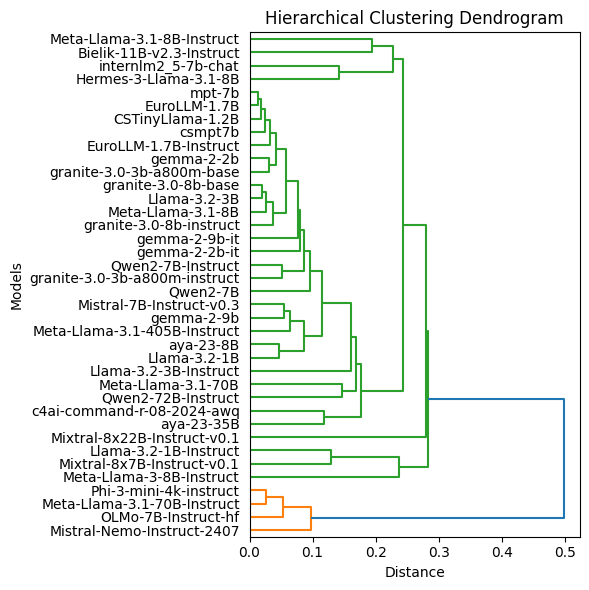

In [73]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# 1. Compute Cosine Distance between tasks (rows)
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

cosine_dist_matrix = pdist(original_scores, metric='cosine')

# 2. Perform hierarchical clustering on the distance matrix
Z = linkage(cosine_dist_matrix, method='average')

# 3. Get the order of rows based on the clustering
sorted_index = leaves_list(Z)

# Reorder the original scores based on hierarchical clustering
clustered_scores = original_scores.iloc[sorted_index]

# Create the heatmap for clustered data
p_heatmap = create_heatmap(clustered_scores, clustered_scores * 100, width=1200)

# Create the dendrogram plot
plt.figure(figsize=(6, 6))
dendrogram(Z, orientation='right', labels=original_scores.index[sorted_index], leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Distance")
plt.ylabel("Models")
plt.tight_layout()
plt.show()

In [74]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, LabelSet, LogColorMapper
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
import numpy as np
from sklearn.preprocessing import normalize

# Step 1: Perform t-SNE on the original_scores
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(original_scores)

# Step 2: Normalize sizes and apply log scale
sizes_log_scaled = np.log1p(sizes_series)  # Use log1p for log(1 + x) to handle zero gracefully
min_size, max_size = sizes_log_scaled.min(), sizes_log_scaled.max()

# Step 3: Prepare a Bokeh data source
source = ColumnDataSource(data={
    "x": tsne_results[:, 0],
    "y": tsne_results[:, 1],
    "model": original_scores.index,
    "size": sizes_series,
    "log_scaled_size": sizes_log_scaled,
})

# Step 4: Create a color mapper using a log scale
color_mapper = LogColorMapper(palette=Viridis256, low=min_size, high=max_size)

# Step 5: Create a Bokeh scatter plot
p_tsne = figure(#title="2D t-SNE Visualization of Models (Log-Scaled Sizes)", 
                #x_axis_label="t-SNE Dimension 1", 
                #y_axis_label="t-SNE Dimension 2", 
                width=1000, height=800)
# Set tick label font sizes
p_tsne.xaxis.major_label_text_font_size = "20pt"  # Set size for x-axis ticks
p_tsne.yaxis.major_label_text_font_size = "20pt"  # Set size for y-axis ticks
# Add scatter points with log-scaled color
p_tsne.scatter(x="x", y="y", size=10, source=source, 
               color={'field': 'log_scaled_size', 'transform': color_mapper}, 
               alpha=0.6)

# Add hover tool to display model names and sizes
hover = HoverTool()
hover.tooltips = [("Model", "@model"), ("Size", "@size")]
p_tsne.add_tools(hover)

# Step 6: Add labels for each point
labels = LabelSet(x="x", y="y", text="model", source=source, 
                  text_font_size="14pt", text_color="black", text_align="center")
p_tsne.add_layout(labels)

# Step 7: Create a color bar for the log-scaled color mapping
color_mapper_original = linear_cmap(field_name='size', 
                                    palette=Viridis256, 
                                    low=sizes_series.min(), 
                                    high=sizes_series.max())
color_bar_original = ColorBar(color_mapper=color_mapper_original['transform'], 
                              width=8, location=(0, 0))
# Step 8: Add the color bar to the plot
p_tsne.add_layout(color_bar_original, 'right')


# Step 9: Show the plot
show(p_tsne)



from bokeh.io import export_svgs
p_tsne.output_backend = "svg"
export_svgs(p_tsne, filename="Model_Similarity_TSNE.svg")


['Model_Similarity_TSNE.svg']

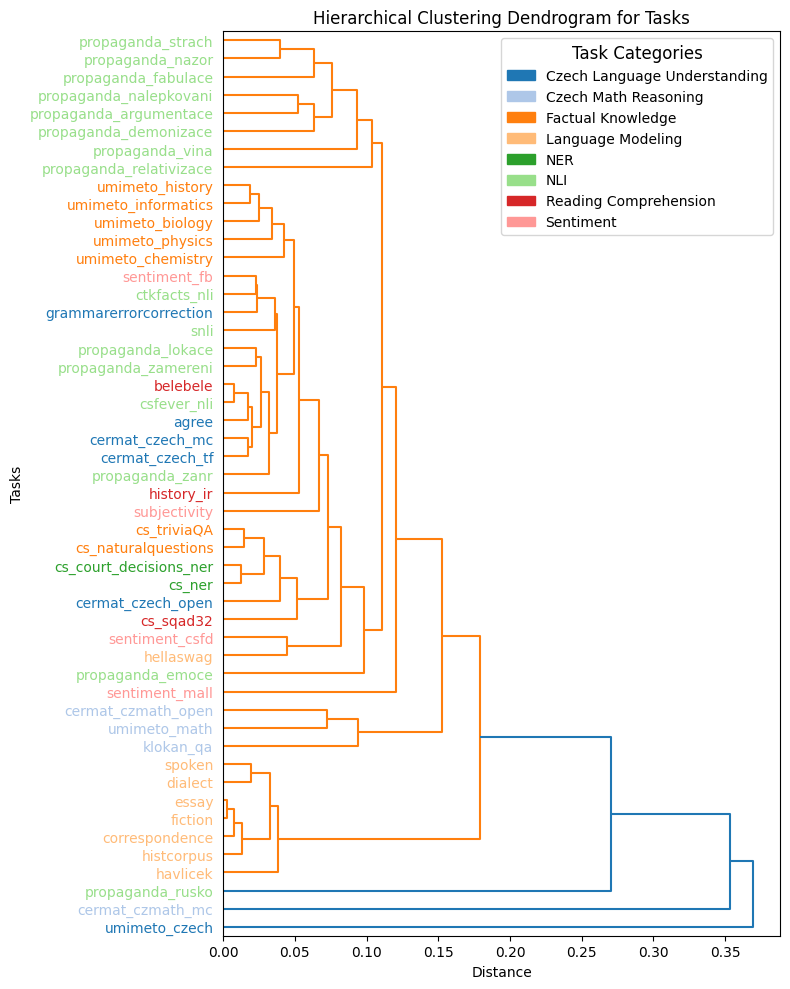

In [75]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from matplotlib import cm
import numpy as np
import matplotlib.patches as mpatches  # For creating legend patches

# Transpose the scores to cluster tasks (columns of original_scores)
task_scores = original_scores.T  # Tasks are rows, models are columns

# 1. Compute Cosine Distance between tasks
cosine_dist_matrix = pdist(task_scores, metric='cosine')

# 2. Perform hierarchical clustering
Z = linkage(cosine_dist_matrix, method='average')

# 3. Map tasks to their categories and assign colors
categories = sorted(set(task_to_category.values()))  # Unique categories
category_color_map = {category: color for category, color in zip(categories, cm.tab20.colors)}
task_categories = [task_to_category.get(task, "Unknown") for task in task_scores.index]
label_colors = [category_color_map[cat] for cat in task_categories]

# 4. Create a custom label coloring function
def color_labels(label):
    task = label
    category = task_to_category.get(task, "Unknown")
    return category_color_map.get(category, "black")  # Default to black if no category

# 5. Modify the dendrogram to apply label colors
plt.figure(figsize=(8, 10))

dendrogram(
    Z,
    orientation="right",
    labels=task_scores.index,
    leaf_font_size=10,
    leaf_label_func=lambda x: f"{task_scores.index[x]}",
    link_color_func=None,  # Optional: Customize link colors based on clusters
)

# Retrieve current figure's axis to access tick labels
ax = plt.gca()
labels = ax.get_yticklabels()
for label in labels:
    task = label.get_text()
    label.set_color(color_labels(task))

# 6. Add a legend for the categories
legend_patches = [
    mpatches.Patch(color=color, label=category) for category, color in category_color_map.items()
]
plt.legend(handles=legend_patches, title="Task Categories", loc="upper right", fontsize="10", title_fontsize="12")

# 7. Plot and display
plt.title("Hierarchical Clustering Dendrogram for Tasks")
plt.xlabel("Distance")
plt.ylabel("Tasks")
plt.tight_layout()
plt.show()


In [76]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, LabelSet
from bokeh.palettes import Category20
from bokeh.transform import factor_cmap

# Step 1: Transpose the scores to make tasks the rows
task_scores = original_scores.T  # Tasks become rows, models are now columns

# Step 2: Perform t-SNE on the transposed task scores
tsne = TSNE(n_components=2, random_state=8, perplexity=6)
tsne_results = tsne.fit_transform(task_scores)

# Step 3: Prepare categories and assign colors
categories = sorted(set(task_to_category.values()))  # Unique categories
category_color_map = {category: color for category, color in zip(categories, Category20[len(categories)])}

# Map each task to its category and color
task_categories = [task_to_category.get(task, "Unknown") for task in task_scores.index]
task_colors = [category_color_map[cat] for cat in task_categories]

# Step 4: Prepare a Bokeh data source
source = ColumnDataSource(data={
    "x": tsne_results[:, 0],
    "y": tsne_results[:, 1],
    "task": task_scores.index,  # Task names
    "category": task_categories,
    "color": task_colors
})

# Step 5: Create a Bokeh scatter plot
p_tsne = figure(#title="2D t-SNE Visualization of Tasks by Category", 
                #x_axis_label="t-SNE Dimension 1", 
                #y_axis_label="t-SNE Dimension 2", 
                width=1000, height=800)
# Set tick label font sizes
p_tsne.xaxis.major_label_text_font_size = "20pt"  # Set size for x-axis ticks
p_tsne.yaxis.major_label_text_font_size = "20pt"  # Set size for y-axis ticks
# Add scatter points
p_tsne.scatter(x="x", y="y", size=10, source=source, color="color", alpha=0.6, legend_group="category")

# Add hover tool to display task names and categories
hover = HoverTool()
hover.tooltips = [("Task", "@task"), ("Category", "@category")]
p_tsne.add_tools(hover)

# Add legend
p_tsne.legend.title = "Categories"
p_tsne.legend.label_text_font_size = "12pt"

# Add labels for each point
labels = LabelSet(x="x", y="y", text="task", source=source, 
                  text_font_size="12pt", text_color="black", text_align="center")
#p_tsne.add_layout(labels)

from bokeh.models import Range1d
p_tsne.x_range = Range1d(start=-29, end=36)


# Step 6: Show the plot
show(p_tsne)


from bokeh.io import export_svgs
p_tsne.output_backend = "svg"
export_svgs(p_tsne, filename="Task_Similarity_TSNE.svg")



['Task_Similarity_TSNE.svg']

In [77]:
# Step 3: Filter out tasks from the "Language Modeling" category
excluded_category = "Language Modeling"

# Create a mask to exclude tasks from the specified category
mask = [task_to_category[task] != excluded_category for task in task_scores.index]

# Apply the mask to filter the data
filtered_task_scores = task_scores[mask]
filtered_task_categories = [task_to_category[task] for task in filtered_task_scores.index]

# Update the t-SNE input with filtered task scores
tsne_results = tsne.fit_transform(filtered_task_scores)

# Prepare updated colors and categories
filtered_categories = sorted(set(filtered_task_categories))
filtered_category_color_map = {cat: color for cat, color in zip(filtered_categories, Category20[len(filtered_categories)])}
filtered_task_colors = [filtered_category_color_map[cat] for cat in filtered_task_categories]

# Step 4: Prepare a Bokeh data source with filtered data
source = ColumnDataSource(data={
    "x": tsne_results[:, 0],
    "y": tsne_results[:, 1],
    "task": filtered_task_scores.index,  # Filtered task names
    "category": filtered_task_categories,
    "color": filtered_task_colors
})

# Step 5-6: Rest of the code remains unchanged
p_tsne = figure(width=1000, height=800)
p_tsne.xaxis.major_label_text_font_size = "20pt"
p_tsne.yaxis.major_label_text_font_size = "20pt"
p_tsne.scatter(x="x", y="y", size=10, source=source, color="color", alpha=0.6, legend_group="category")

hover = HoverTool()
hover.tooltips = [("Task", "@task"), ("Category", "@category")]
p_tsne.add_tools(hover)

p_tsne.legend.title = "Categories"
p_tsne.legend.label_text_font_size = "12pt"

labels = LabelSet(x="x", y="y", text="task", source=source, 
                  text_font_size="12pt", text_color="black", text_align="center")
p_tsne.add_layout(labels)

from bokeh.models import Range1d
#p_tsne.x_range = Range1d(start=-29, end=36)

show(p_tsne)

from bokeh.io import export_svgs
p_tsne.output_backend = "svg"
export_svgs(p_tsne, filename="Task_Similarity_TSNE_Without_Language_Modeling.svg")


['Task_Similarity_TSNE_Without_Language_Modeling.svg']